# ■ 재구매 상품 예측

* 팀명 : JB9
* 팀원 : 유별나, 박성실, 이소연

# Contents
1. overview
2. Step1. 분석 배경 및 계획 수립
3. Step2. 데이터 분석/시각화
4. Step3. 데이터 전처리 / 변수 생성
5. Step4. Feature Engineering
6. Step5. Modeling
7. Step6. 최종결과
8. Step7. 제언 및 느낀점

# Overview
* 고객의 과거 구매 이력과 현재 구매 정보를 활용하여, 과거 구매 상품 중 현재 재구매 할 만한 상품을 제안하고자 함. <br>
* 고객의 구매 패턴에 따라 상품 추천 가능하고, 고객이 놓칠 수 있는 상품 또한 추천 가능함.

# Step1. 분석 배경 및 계획 수립
* 기업에서 판매하는 수많은 상품들 중 고객이 원하는 상품을 구매 패턴에 맞춰 구매하는 것이 어려움.
* 따라서, 고객의 과거 구매 이력과 현재 구매 정보를 활용하여, 과거 구매 상품 중 현재 재구매 할 만한 상품을 제안하고자 함.
* 분석 목표 : ①고객에게 구매 패턴에 따른 상품과 고객이 놓칠 수 있는 상품 추천 가능 / ②고객의 구매/재구매 확률을 높임으로써 기업의 매출 증대에 기여.
* 분석 방향 : training / validation / Testing set으로 나누어 모델링을 통한 예측을 하고자함.

# Step2. 데이터 분석 및 시각화

## 0. Import Module

In [1]:
from jbfg.pandas_utils import *
import pickle
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import calendar
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## 1. Data Analysis

### 1-1. products_info

* 상품 정보에 대해 담당부서별(division_id) / 분류별(category_name) 로 구분하여 데이터 탐색
* 9개 부서, 21개 카테고리, 100개 상품이 존재함.

In [2]:
schema = 'l2_jbbk_extnl'

In [3]:
sql = 'SELECT * FROM products_info'
df_products_info = get_df(sql, schema)
df_products_info.tail()

,product_id,name,category_id,division_id,category_name,division_name
95,47209,Organic Hass Avocado,24,4,fresh fruits,produce
96,21903,Organic Baby Spinach,123,4,packaged vegetables fruits,produce
97,21137,Organic Strawberries,24,4,fresh fruits,produce
98,13176,Bag of Organic Bananas,24,4,fresh fruits,produce
99,24852,Banana,24,4,fresh fruits,produce


In [4]:
df_products_info['category_id'] = df_products_info['category_id'].astype(int)
df_products_info['division_id'] = df_products_info['division_id'].astype(int)
df_products_info['product_id'] = df_products_info['product_id'].astype(int)

In [5]:
# products_info 를 division_id, category_id, product_id 로 정렬
df_products_info_ch = df_products_info.sort_values(by=['division_id','category_id','product_id'])
df_products_info_ch

,product_id,name,category_id,division_id,category_name,division_name
50,9076,Blueberries,116,1,frozen produce,frozen
1,20995,Organic Broccoli Florets,116,1,frozen produce,frozen
58,5077,100% Whole Wheat Bread,112,3,bread,bakery
34,28842,Bunched Cilantro,16,4,fresh herbs,produce
66,31717,Organic Cilantro,16,4,fresh herbs,produce
...,...,...,...,...,...,...
39,24838,Unsweetened Almondmilk,91,16,soy lactosefree,dairy eggs
54,35951,Organic Unsweetened Almond Milk,91,16,soy lactosefree,dairy eggs
4,47144,Unsweetened Original Almond Breeze Almond Milk,91,16,soy lactosefree,dairy eggs
67,30489,Original Hummus,67,20,fresh dips tapenades,deli


* 담당부서별 관리하는 상품의 수

In [6]:
pro_cnt = df_products_info_ch.groupby(['division_name'], dropna=False).agg(cnt=('name','count')).reset_index()
pro_cnt = pro_cnt.sort_values('cnt',ascending=False)

<BarContainer object of 9 artists>

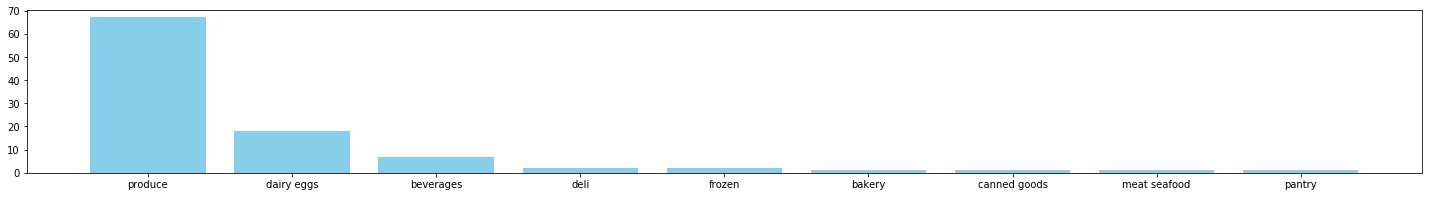

In [7]:
plt.figure(figsize=(25, 3))
plt.bar(pro_cnt['division_name'], pro_cnt['cnt'], color='skyblue')

* 카테고리별 상품의 수

In [8]:
cate_cnt = df_products_info_ch.groupby(['category_name'], dropna=False).agg(cnt=('name','count')).reset_index()
cate_cnt = cate_cnt.sort_values('cnt',ascending=False)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 <a list of 21 Text xticklabel objects>)

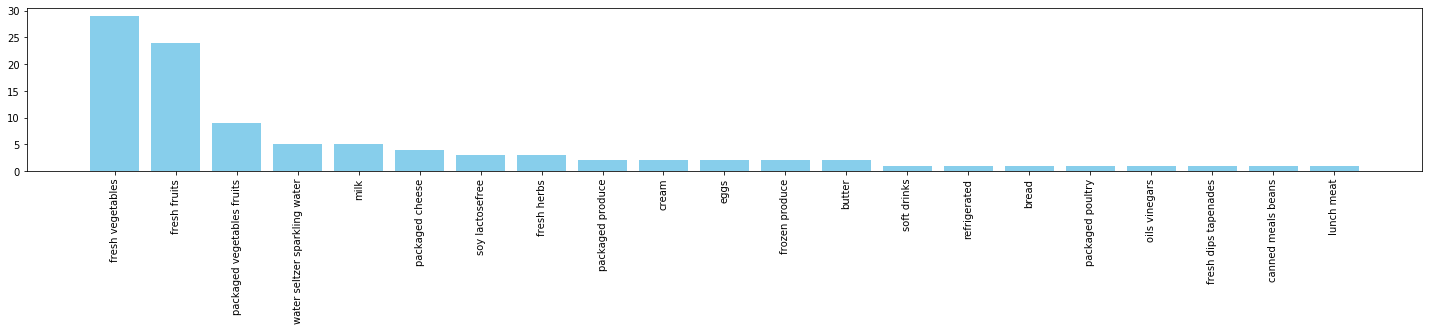

In [9]:
plt.figure(figsize=(25, 3))
plt.bar(cate_cnt['category_name'], cate_cnt['cnt'], color='skyblue')
plt.xticks(rotation='vertical')

### 1-2. train_x_past

In [10]:
sql = 'SELECT * FROM train_x_past'
df_train_x_past = get_df(sql, schema)
df_train_x_past.tail()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
1253967,1902783,163819,47,0,19,13.0,2,1,24852
1253968,1969590,163819,42,1,15,6.0,3,1,24852
1253969,2549215,163819,9,1,11,7.0,1,1,24852
1253970,3103211,163819,39,1,14,7.0,3,1,24852
1253971,3207262,163819,8,1,12,7.0,1,1,24852


In [11]:
# 숫자형으로 변환, 빈칸 0으로 채우기
df_train_x_past_ch = df_train_x_past.apply(pd.to_numeric, errors='coerce').fillna(0)

In [12]:
df_train_x_past_ch = df_train_x_past_ch.merge(df_products_info_ch, on='product_id', how='left')
df_train_x_past_ch

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,name,category_id,division_id,category_name,division_name
0,717029,196613,15,1,9,3.0,5,0,41220,Organic Romaine Lettuce,83,4,fresh vegetables,produce
1,2325772,196613,35,6,11,2.0,7,1,41220,Organic Romaine Lettuce,83,4,fresh vegetables,produce
2,642668,196613,69,2,16,2.0,11,1,4210,Whole Milk,84,16,milk,dairy eggs
3,1326515,196613,61,3,19,3.0,3,1,4210,Whole Milk,84,16,milk,dairy eggs
4,1437845,196613,36,3,15,4.0,16,0,4210,Whole Milk,84,16,milk,dairy eggs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253967,1902783,163819,47,0,19,13.0,2,1,24852,Banana,24,4,fresh fruits,produce
1253968,1969590,163819,42,1,15,6.0,3,1,24852,Banana,24,4,fresh fruits,produce
1253969,2549215,163819,9,1,11,7.0,1,1,24852,Banana,24,4,fresh fruits,produce
1253970,3103211,163819,39,1,14,7.0,3,1,24852,Banana,24,4,fresh fruits,produce


### 1-2-0. Master Table 생성

In [13]:
# EDA를 위한 Master Table 생성

* 마스터 테이블 1 (전체거래)

In [14]:
# 순서 정렬
df_train_x_past_1 = df_train_x_past_ch.sort_values(by=['cstno','order_number','add_order'])
df_train_x_past_1

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,name,category_id,division_id,category_name,division_name
1695,3131103,50,2,6,12,10.0,3,0,21137,Organic Strawberries,24,4,fresh fruits,produce
1676,2197066,50,3,1,13,9.0,2,0,47209,Organic Hass Avocado,24,4,fresh fruits,produce
1657,3201640,50,4,0,11,6.0,5,0,24964,Organic Garlic,83,4,fresh vegetables,produce
1613,2756806,50,5,4,14,11.0,6,0,34126,Organic Italian Parsley Bunch,16,4,fresh herbs,produce
1622,1941871,50,9,4,11,5.0,1,0,41950,Organic Tomato Cluster,83,4,fresh vegetables,produce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405997,355332,206124,57,1,7,10.0,6,1,49235,Organic Half & Half,53,16,cream,dairy eggs
405992,72602,206124,58,5,15,4.0,6,1,49235,Organic Half & Half,53,16,cream,dairy eggs
405973,1113246,206124,59,5,13,7.0,7,1,47144,Unsweetened Original Almond Breeze Almond Milk,91,16,soy lactosefree,dairy eggs
406005,1484260,206124,61,1,8,6.0,3,1,49235,Organic Half & Half,53,16,cream,dairy eggs


* 마스터 테이블2 (고객별/주문번호별 테이블 - 상품정보 제외)

In [15]:
df_train_x_past_2 = df_train_x_past_1.drop_duplicates(['cstno','order_number'],keep='last')
df_train_x_past_2 = df_train_x_past_2[['order_id','cstno','order_number','week_day','order_hour','order_interval']]
df_train_x_past_2

,order_id,cstno,order_number,week_day,order_hour,order_interval
1695,3131103,50,2,6,12,10.0
1676,2197066,50,3,1,13,9.0
1657,3201640,50,4,0,11,6.0
1613,2756806,50,5,4,14,11.0
1612,1941871,50,9,4,11,5.0
...,...,...,...,...,...,...
405997,355332,206124,57,1,7,10.0
405992,72602,206124,58,5,15,4.0
405973,1113246,206124,59,5,13,7.0
406005,1484260,206124,61,1,8,6.0


### 1-2-1. 고객별 가장 주문이 많은 요일

* conclusion : 일요일과 월요일에 구매가 가장 많음.

In [16]:
df_train_x_past_2['week_day'].value_counts()

1    60072
0    56711
5    47830
2    46057
4    44489
3    44448
6    42071
Name: week_day, dtype: int64

In [17]:
df_train_x_past_2_1 = df_train_x_past_2.groupby(['cstno','week_day'], dropna=False).agg(weekday_gu=('week_day','count')).reset_index()
df_train_x_past_2_1 = df_train_x_past_2_1.sort_values(['cstno','weekday_gu'],ascending=True)
df_train_x_past_2_1 = df_train_x_past_2_1.drop_duplicates(['cstno'],keep='last')
df_train_x_past_2_1 = df_train_x_past_2_1.groupby(['week_day'], dropna=False).agg(cnt=('cstno','count')).reset_index()

<BarContainer object of 7 artists>

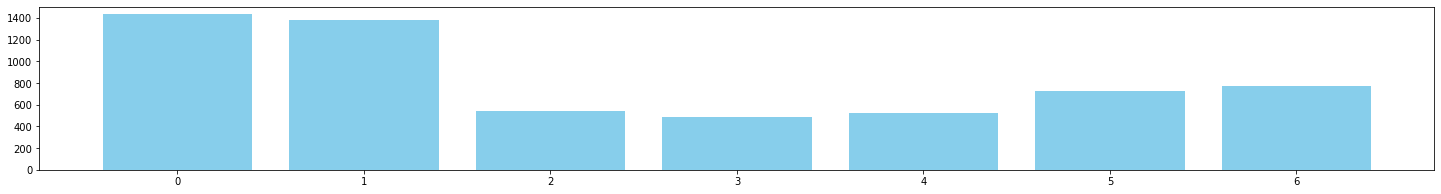

In [18]:
plt.figure(figsize=(25, 3))
plt.bar(df_train_x_past_2_1['week_day'], df_train_x_past_2_1['cnt'], color='skyblue')

### 1-2-2. 고객별 가장 주문이 많은 시간

* conclusion : 7~18시까지 대부분 주문이 이루어지며, 오전 9시에 주문이 가장 많음 

In [19]:
df_train_x_past_2_2 = df_train_x_past_2.groupby(['cstno','order_hour'], dropna=False).agg(order_hour_gu=('order_hour','count')).reset_index()
df_train_x_past_2_2 = df_train_x_past_2_2.sort_values(['cstno','order_hour_gu'],ascending=True)
df_train_x_past_2_2 = df_train_x_past_2_2.drop_duplicates(['cstno'],keep='last')
df_train_x_past_2_2 = df_train_x_past_2_2.groupby(['order_hour'], dropna=False).agg(cnt=('cstno','count')).reset_index()

<BarContainer object of 23 artists>

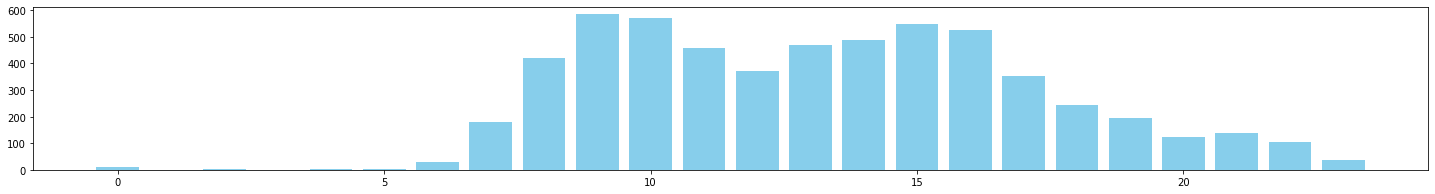

In [20]:
plt.figure(figsize=(25, 3))
plt.bar(df_train_x_past_2_2['order_hour'], df_train_x_past_2_2['cnt'], color='skyblue')

### 1-2-3. 고객별 가장 많은 주문간격

* conclusion : 주문 간격은 0~14일 사이에 분포하며, 7일 간격으로 주문하는 고객이 가장 많음.
* 주문 간격별 상품 분포를 보면, banana와 Organic Strawberries가 많은데, 상품 판매량이 많아서 인것 같아 큰 의미 없어 보임.

In [21]:
df_train_x_past_2_3 = df_train_x_past_2.groupby(['cstno','order_interval'], dropna=False).agg(order_interval_gu=('order_interval','count')).reset_index()
df_train_x_past_2_3 = df_train_x_past_2_3.sort_values(['cstno','order_interval_gu'],ascending=True)
df_train_x_past_2_3 = df_train_x_past_2_3.drop_duplicates(['cstno'],keep='last')
df_train_x_past_2_3 = df_train_x_past_2_3.groupby(['order_interval'], dropna=False).agg(cnt=('cstno','count')).reset_index()

<BarContainer object of 13 artists>

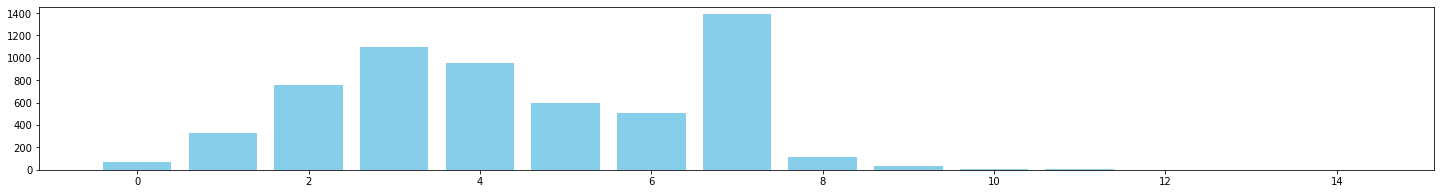

In [22]:
plt.figure(figsize=(25, 3))
plt.bar(df_train_x_past_2_3['order_interval'], df_train_x_past_2_3['cnt'], color='skyblue')

### 1-2-4. 고객별 가장 주문이 많은 상품

* conclusion : 고객별 최다 구매 상품은 Banana 와 Bag of Orgarnic Bananas 임.

In [23]:
df_train_x_past_2_4 = df_train_x_past_1.groupby(['cstno','product_id','name'], dropna=False).agg(product_gu=('product_id','count')).reset_index()
df_train_x_past_2_4 = df_train_x_past_2_4.sort_values(['cstno','product_gu'],ascending=True)
df_train_x_past_2_4 = df_train_x_past_2_4.drop_duplicates(['cstno'],keep='last')
df_train_x_past_2_4 = df_train_x_past_2_4.groupby(['product_id','name'], dropna=False).agg(cnt=('cstno','count')).reset_index()
df_train_x_past_2_4 = df_train_x_past_2_4.sort_values('cnt',ascending=False).head(10)

<BarContainer object of 10 artists>

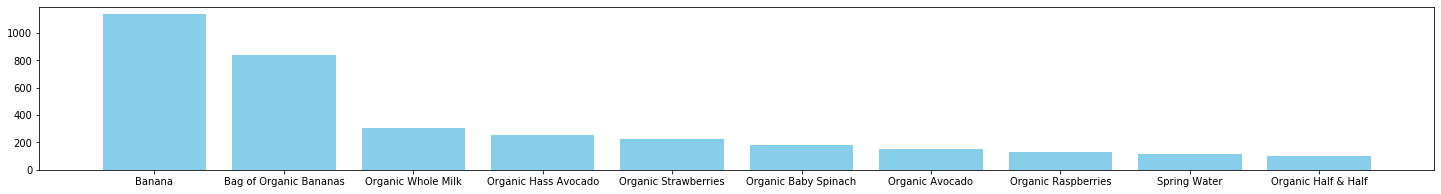

In [24]:
plt.figure(figsize=(25, 3))
plt.bar(df_train_x_past_2_4['name'], df_train_x_past_2_4['cnt'], color='skyblue')

### 1-2-5. 고객별 가장 많이 재구매한 상품

* 고객별 가장 많이 재구매한 상품은 Banana와 Bag of Orgarnic Bananas 이며, 주문이 많은 상품과 거의 비슷함.

In [25]:
df_train_x_past_2_5 = df_train_x_past_1.groupby(['cstno','name'], dropna=False).agg(re_gu=('is_reordered','count')).reset_index()
df_train_x_past_2_5 = df_train_x_past_2_5.sort_values(['cstno','re_gu'],ascending=True)
df_train_x_past_2_5 = df_train_x_past_2_5.drop_duplicates(['cstno'],keep='last')
df_train_x_past_2_5 = df_train_x_past_2_5.groupby(['name'], dropna=False).agg(cnt=('cstno','count')).reset_index()
df_train_x_past_2_5 = df_train_x_past_2_5.sort_values('cnt',ascending=False).head(10)

<BarContainer object of 10 artists>

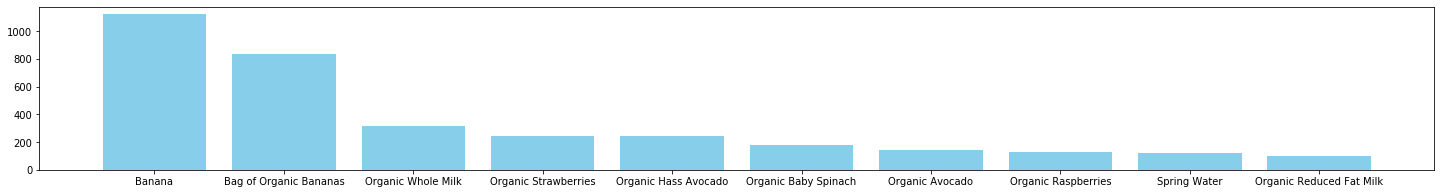

In [26]:
plt.figure(figsize=(25, 3))
plt.bar(df_train_x_past_2_5['name'], df_train_x_past_2_5['cnt'],color='skyblue')

### 1-2-6. 고객별 가장 많은 구매횟수

* conclusion : 고객별 구매횟수는 42~99회까지 있으며, 43회가 가장 많음.

In [27]:
df_train_x_past_2_6 = df_train_x_past_2.groupby(['cstno'], dropna=False).agg(order_number_gu=('order_number','count')).reset_index()
df_train_x_past_2_6 = df_train_x_past_2_6.groupby(['order_number_gu'], dropna=False).agg(cnt=('cstno','count')).reset_index()

<BarContainer object of 58 artists>

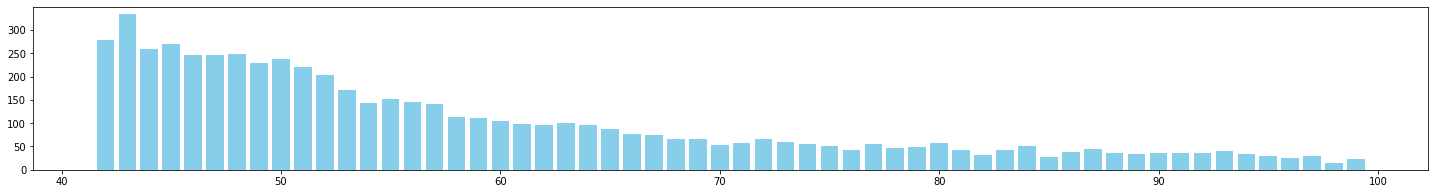

In [28]:
plt.figure(figsize=(25, 3))
plt.bar(df_train_x_past_2_6['order_number_gu'], df_train_x_past_2_6['cnt'], color='skyblue')

### 1-2-7. 고객별 한번에 구매하는 평균 상품개수

* conclusion : 고객은 한번에 평균 1~15개 상품을 구매하며, 3개 구매하는 경우가 가장 많음.

In [29]:
df_train_x_past_2_7 = df_train_x_past_1.groupby(['cstno','order_number'], dropna=False).agg(cnt_prod=('product_id','count')).reset_index()
df_train_x_past_2_7 = df_train_x_past_2_7.sort_values(['cstno','cnt_prod'],ascending=True)
df_train_x_past_2_7 = df_train_x_past_2_7.groupby(['cstno'], dropna=False).agg(cnt_prod=('cnt_prod','mean')).reset_index()
df_train_x_past_2_7['cnt_prod'] = round(df_train_x_past_2_7['cnt_prod'])
df_train_x_past_2_7 = df_train_x_past_2_7.groupby(['cnt_prod'], dropna=False).agg(cnt=('cstno','count')).reset_index()

<BarContainer object of 14 artists>

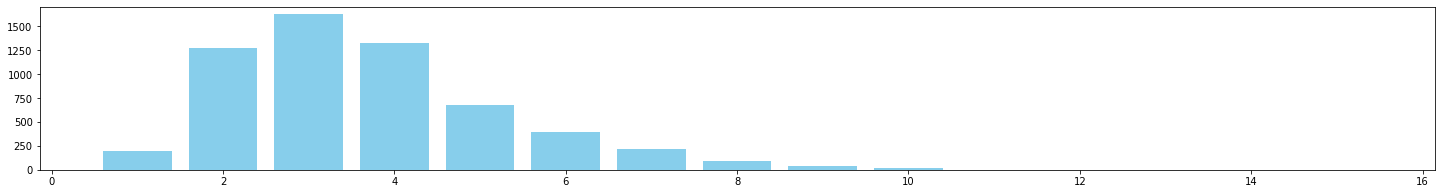

In [30]:
plt.figure(figsize=(25, 3))
plt.bar(df_train_x_past_2_7['cnt_prod'], df_train_x_past_2_7['cnt'], color='skyblue')

### 1-2-8. 당일 재주문시 가장 많이 주문하는 상품

* conclusion : 당일 재주문시 Banana, Organic Strawberries, Bag of Organic Bananas를 가장 많이 구매함

In [31]:
df_train_x_past_2_8 = df_train_x_past_1[df_train_x_past_1['order_interval']==0.0]
df_train_x_past_2_8 = df_train_x_past_2_8.groupby(['name'], dropna=False).agg(product_cnt=('cstno','count')).reset_index()
df_train_x_past_2_8 = df_train_x_past_2_8.sort_values(['product_cnt'], ascending=False)

<BarContainer object of 100 artists>

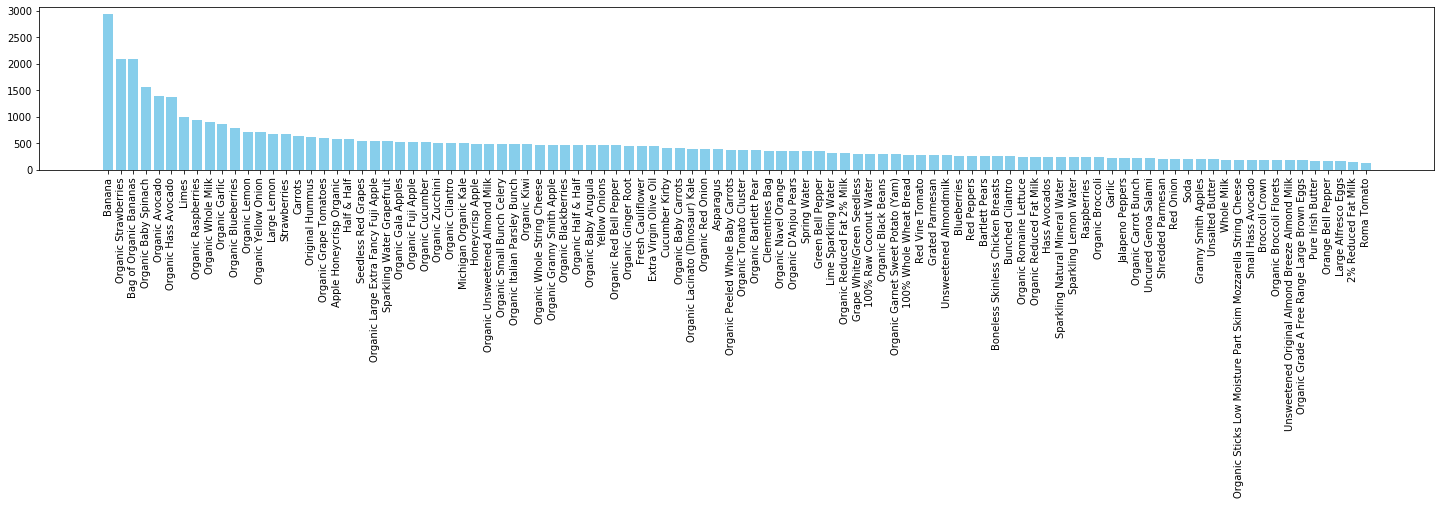

In [32]:
plt.figure(figsize=(25, 3))
plt.xticks(size=10, rotation='vertical')
plt.bar(df_train_x_past_2_8['name'], df_train_x_past_2_8['product_cnt'], color='skyblue')

### 1-2-9. 장바구니에 가장 먼저 담는 제품

* conclusion : 장바구니에 가장 먼저 담는 상품은 Banana, Bag of Organic Bananas, Organic Whole Mile 임. 필수 상품이라고 봐도 될듯함.

In [33]:
#첫번째로 담고 주문한 제품만 봄. 주문하지 않은 제품 제외
df_train_x_past_2_9 = df_train_x_past_1[df_train_x_past_1['add_order']==1]
df_train_x_past_2_9 = df_train_x_past_2_9.groupby(['name'], dropna=False).agg(product_cnt=('cstno','count')).reset_index()
df_train_x_past_2_9 = df_train_x_past_2_9.sort_values(['product_cnt'], ascending=False)

<BarContainer object of 100 artists>

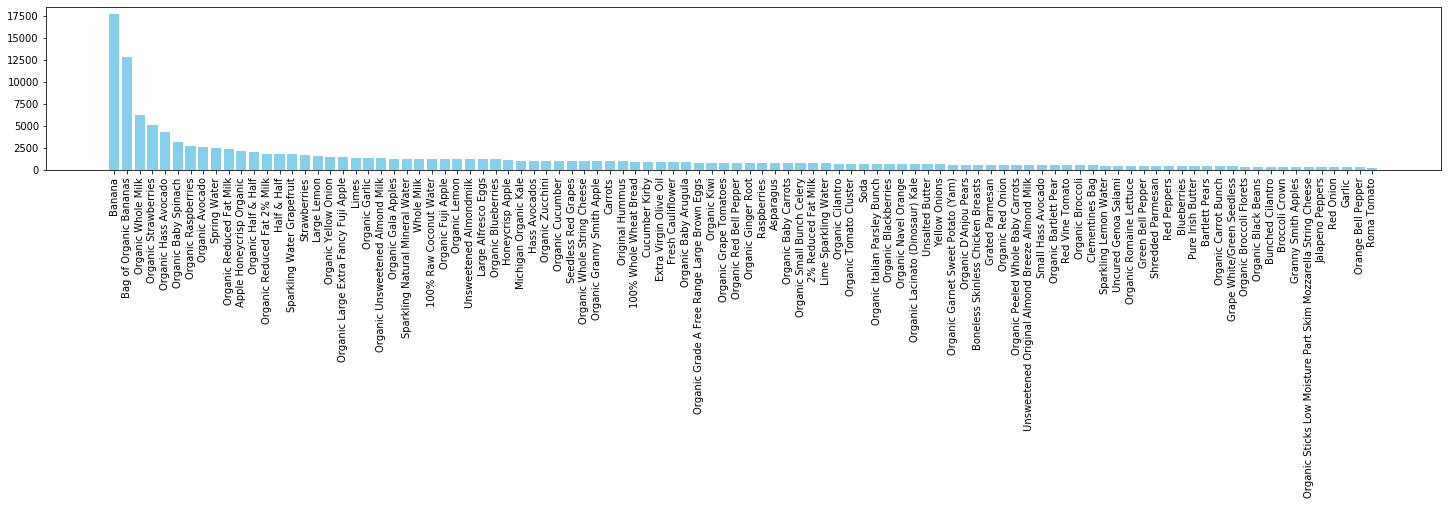

In [34]:
plt.figure(figsize=(25, 3))
plt.xticks(size=10, rotation='vertical')
plt.bar(df_train_x_past_2_9['name'], df_train_x_past_2_9['product_cnt'], color='skyblue')

### 1-2-10. 첫 주문시 가장 많이 주문하는 상품

* conclusion : 고객이 첫 주문할때 Banana와 Organic Strawberries를 가장 많이 구매함. 해당 상품들을 사기 위해 고객이 유입될 가능성이 높음.

In [35]:
# 최초 주문번호 찾기
df_train_x_past_ch_prod_f = df_train_x_past_1.groupby(['cstno'], dropna=False).agg(order_number=('order_number','min')).reset_index()
df_train_x_past_ch_prod_f['min_yn']=1
df_train_x_past_ch_prod_f = df_train_x_past_1.merge(df_train_x_past_ch_prod_f, on=['cstno','order_number'], how='left')
df_train_x_past_ch_prod_f

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,name,category_id,division_id,category_name,division_name,min_yn
0,3131103,50,2,6,12,10.0,3,0,21137,Organic Strawberries,24,4,fresh fruits,produce,1.0
1,2197066,50,3,1,13,9.0,2,0,47209,Organic Hass Avocado,24,4,fresh fruits,produce,NaN
2,3201640,50,4,0,11,6.0,5,0,24964,Organic Garlic,83,4,fresh vegetables,produce,NaN
3,2756806,50,5,4,14,11.0,6,0,34126,Organic Italian Parsley Bunch,16,4,fresh herbs,produce,NaN
4,1941871,50,9,4,11,5.0,1,0,41950,Organic Tomato Cluster,83,4,fresh vegetables,produce,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253967,355332,206124,57,1,7,10.0,6,1,49235,Organic Half & Half,53,16,cream,dairy eggs,NaN
1253968,72602,206124,58,5,15,4.0,6,1,49235,Organic Half & Half,53,16,cream,dairy eggs,NaN
1253969,1113246,206124,59,5,13,7.0,7,1,47144,Unsweetened Original Almond Breeze Almond Milk,91,16,soy lactosefree,dairy eggs,NaN
1253970,1484260,206124,61,1,8,6.0,3,1,49235,Organic Half & Half,53,16,cream,dairy eggs,NaN


In [36]:
df_train_x_past_ch_prod_f = df_train_x_past_ch_prod_f[df_train_x_past_ch_prod_f['min_yn']==1]
df_train_x_past_ch_prod_f = df_train_x_past_ch_prod_f.groupby(['name'], dropna=False).agg(product_cnt=('name','count')).reset_index()
df_train_x_past_ch_prod_f = df_train_x_past_ch_prod_f.sort_values(['product_cnt'], ascending=False)
df_train_x_past_ch_prod_f

,name,product_cnt
6,Banana,1380
71,Organic Strawberries,1252
5,Bag of Organic Bananas,979
32,Organic Avocado,947
35,Organic Baby Spinach,745
...,...,...
2,2% Reduced Fat Milk,66
84,Roma Tomato,65
89,Sparkling Lemon Water,61
87,Small Hass Avocado,61


<BarContainer object of 100 artists>

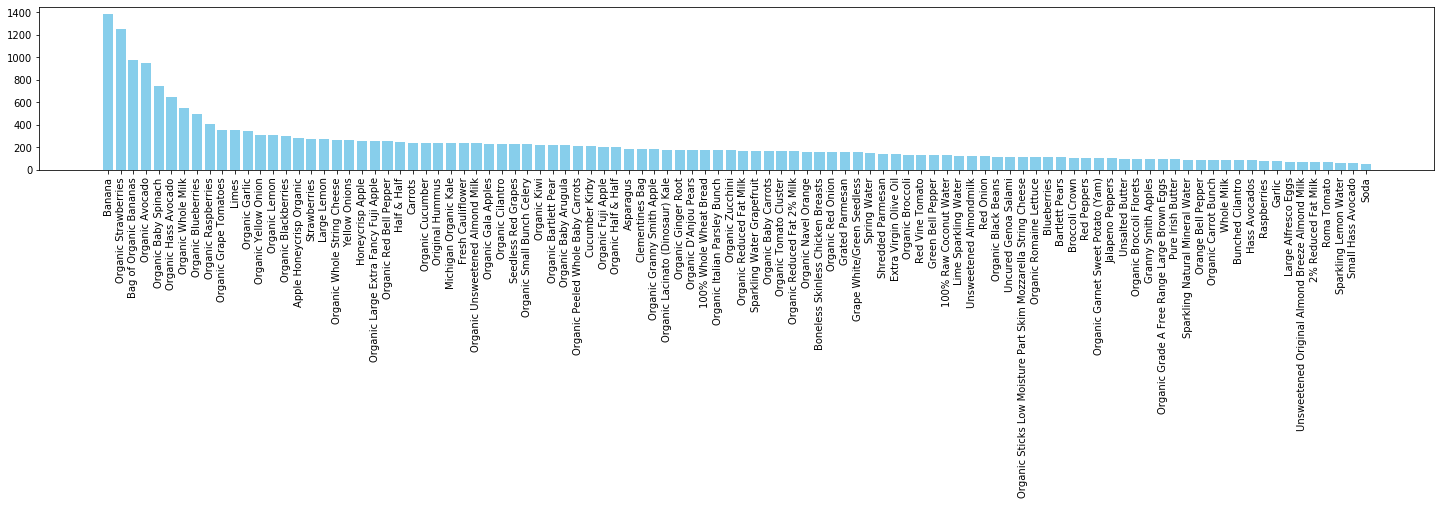

In [37]:
plt.figure(figsize=(25, 3))
plt.xticks(size=10, rotation='vertical')
plt.bar(df_train_x_past_ch_prod_f['name'], df_train_x_past_ch_prod_f['product_cnt'], color='skyblue')

## 2. Bivariate

해당 파트에서는 재구매 특성을 파악하기 위해 재구매한 건에 대해서만 보기로 함. (is_reordered=1)

In [38]:
bi_data = df_train_x_past_1
bi_data = bi_data[bi_data.is_reordered==1]
bi_data.tail()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,name,category_id,division_id,category_name,division_name
405997,355332,206124,57,1,7,10.0,6,1,49235,Organic Half & Half,53,16,cream,dairy eggs
405992,72602,206124,58,5,15,4.0,6,1,49235,Organic Half & Half,53,16,cream,dairy eggs
405973,1113246,206124,59,5,13,7.0,7,1,47144,Unsweetened Original Almond Breeze Almond Milk,91,16,soy lactosefree,dairy eggs
406005,1484260,206124,61,1,8,6.0,3,1,49235,Organic Half & Half,53,16,cream,dairy eggs
405974,2329698,206124,62,1,8,7.0,3,1,47144,Unsweetened Original Almond Breeze Almond Milk,91,16,soy lactosefree,dairy eggs


### 2-1. week_day & order_hour

### 2-2. week_day & order_interval

* conclusion1 : 7~17시 사이에 재구매가 가장 많으며, 월요일 10시에 가장 재구매가 많음.
* conclusion2 : 재구매 간격은 1~7일이 가장 많으며, 7일에 한번 일요일 또는 월요일에 재구매하는 고객이 가장 많음.

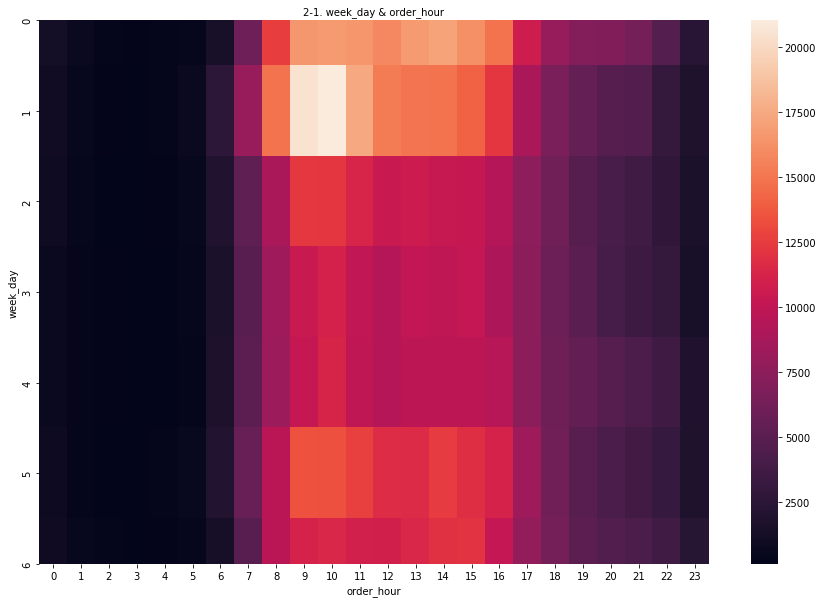

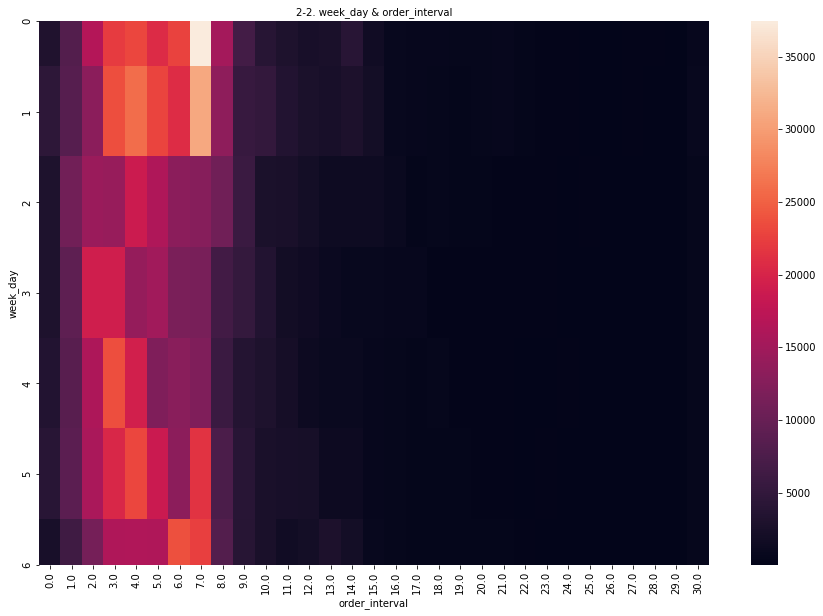

In [39]:
a = [['week_day','order_hour'],['week_day','order_interval']]
b = ['order_hour','order_interval']
c = ['2-1.','2-2.']

for i in range(2):
    corelation = bi_data.groupby(a[i])['is_reordered'].aggregate('count').reset_index()
    corelation = corelation.pivot(index='week_day', columns=b[i], values='is_reordered')
    # corelation = corelation.fillna(0)
    plt.figure(figsize=(15,10))
    sns.heatmap(corelation)
    plt.title(str(c[i]) + " week_day & " + str(b[i]), fontsize=10)
    plt.show()

### 2-3. order_hour & order_interval

* conclusion : 7일 이내 간격으로 재구매가 많으며, 8~16시 사이 재구매가 가장 많음.

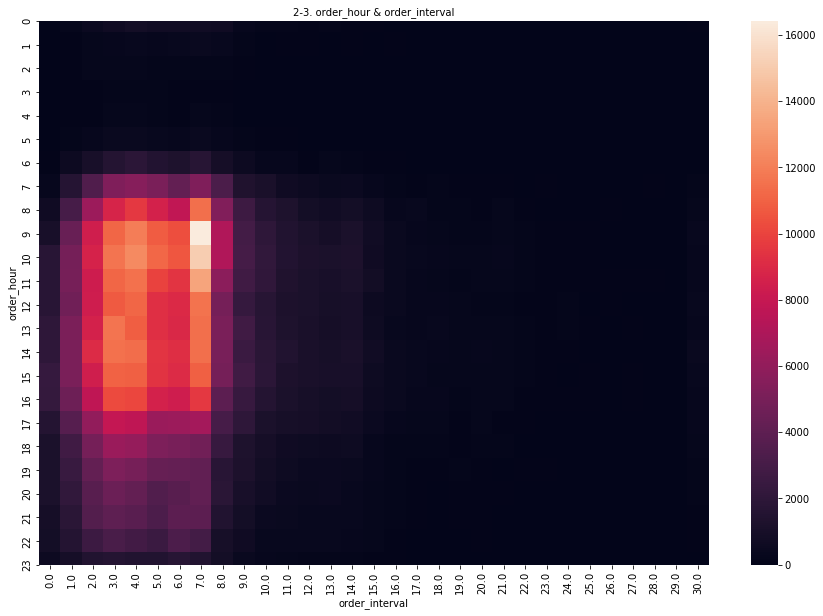

In [40]:
corelation = bi_data.groupby(['order_hour','order_interval'])['is_reordered'].aggregate('count').reset_index()
corelation = corelation.pivot(index='order_hour',columns='order_interval', values='is_reordered')
corelation = corelation.fillna(0)
plt.figure(figsize=(15,10))
sns.heatmap(corelation)
plt.title("2-3. order_hour & order_interval", fontsize=10)
plt.show()

### 2-4. add_order & week_day

### 2-5. add_order & order_hour

### 2-6. add_order & order_interval

* conclusion1 : 장바구니 담은 순서가 빠를수록 구매가 많으며, 월요일이 가장 많음.
* conclusion2 : 9~10시 사이 주문이 가장 많으며, 장바구니 담은 순서가 빠를수로 구매 많음.
* conclusion3 : 주문간격 3~4일간격의 빨리 담은 상품들의 구매가 많으며, 7일 간격에는 뒤에 담은 상품들도 많이 구매함.

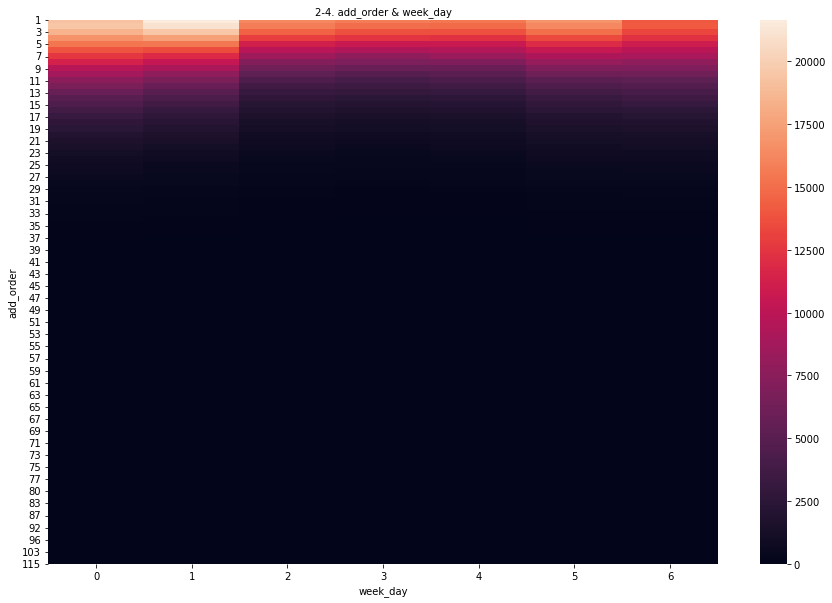

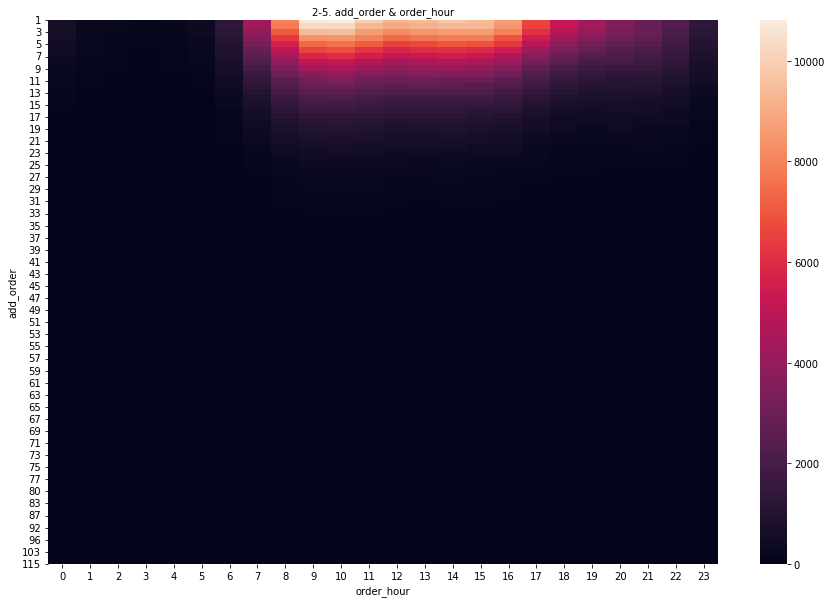

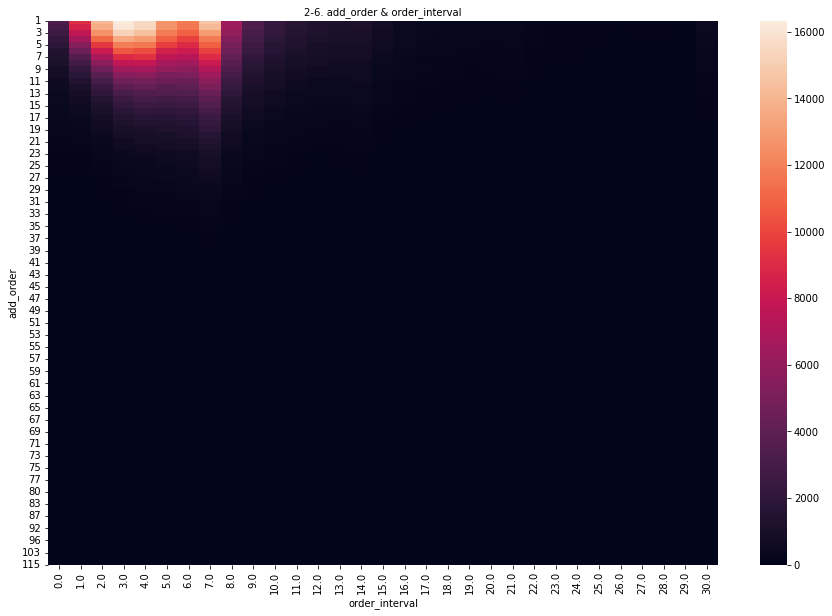

In [41]:
a = [['add_order','week_day'],['add_order','order_hour'],['add_order','order_interval']]
b = ['week_day','order_hour','order_interval']
c = ['2-4.','2-5.','2-6.']

for i in range(3):
    corelation = bi_data.groupby(a[i])['is_reordered'].aggregate('count').reset_index()
    corelation = corelation.pivot(index='add_order', columns=b[i], values='is_reordered')
    corelation = corelation.fillna(0)
    plt.figure(figsize=(15,10))
    sns.heatmap(corelation)
    plt.title(str(c[i]) + " add_order & " + str(b[i]), fontsize=10)
    plt.show()

### 2-7. name & week_day
### 2-8. name & order_hour
### 2-9. name & order_interval

* conclusion : 상품별 요일, 시간, 주문 간격이 다르다기보다는, Banana, Bag of Organic Bananas, Organic Strawberries의 주문이 많은 영향임. 요일,시간,주문 간격별 대세는 1-2와 같음.

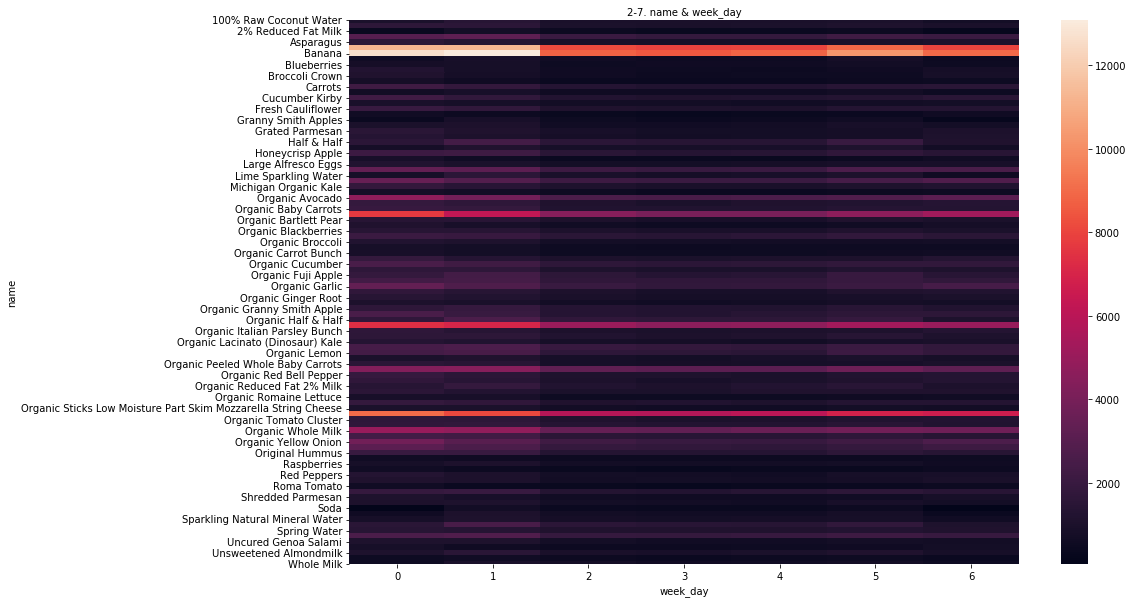

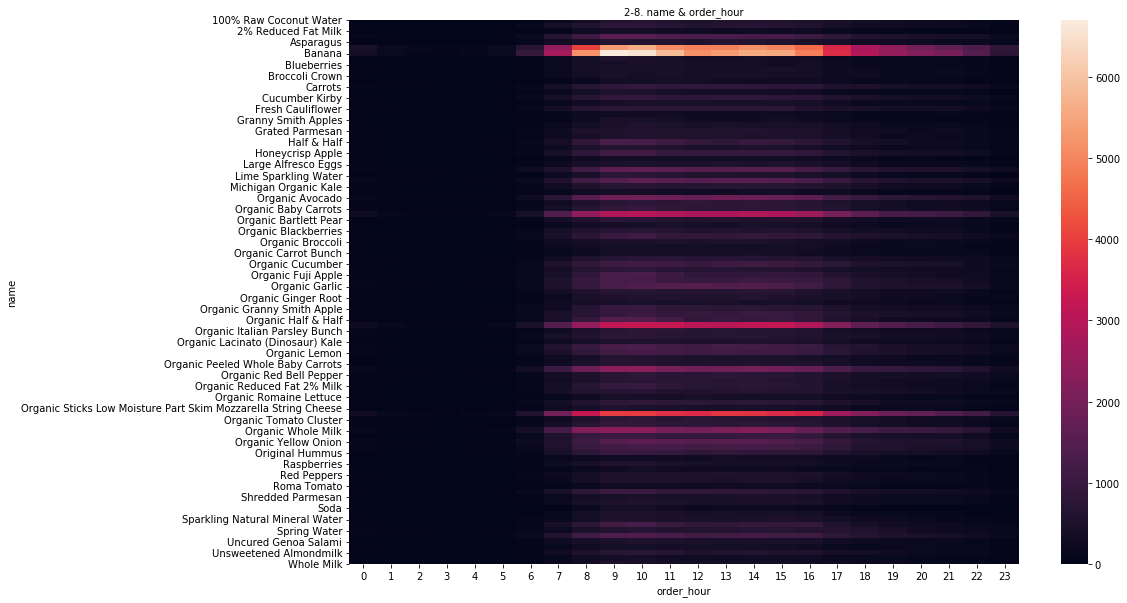

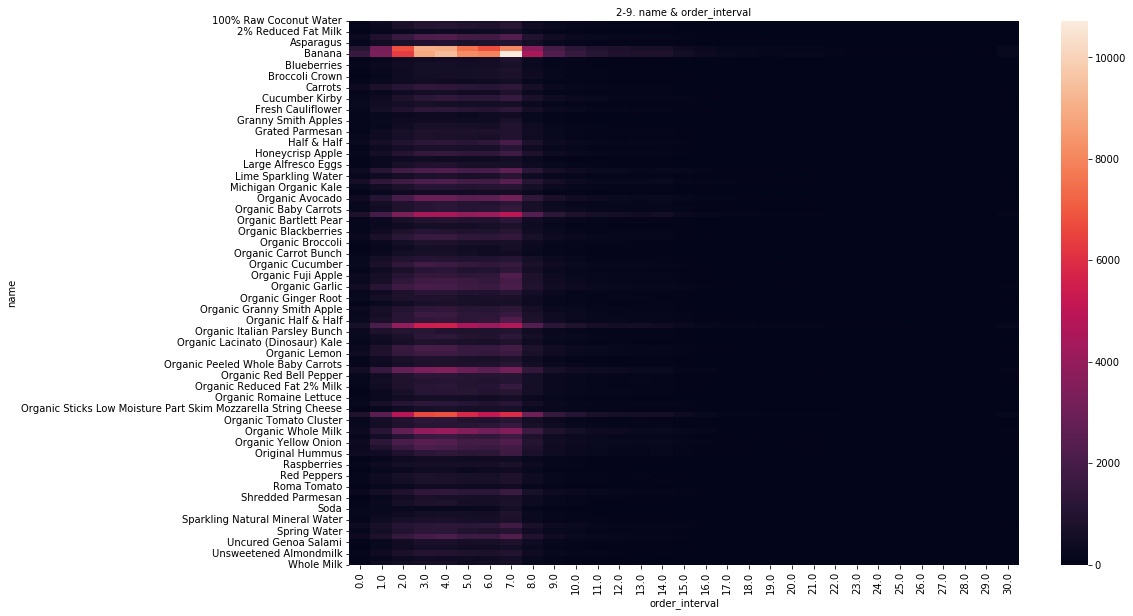

In [42]:
a = [['name','week_day'],['name','order_hour'],['name','order_interval']]
b = ['week_day','order_hour','order_interval']
c = ['2-7.','2-8.','2-9.']

for i in range(3):
    corelation = bi_data.groupby(a[i])['is_reordered'].aggregate('count').reset_index()
    corelation = corelation.pivot(index='name', columns=b[i], values='is_reordered')
    corelation = corelation.fillna(0)
    plt.figure(figsize=(15,10))
    sns.heatmap(corelation)
    plt.title(str(c[i]) + " name & " + str(b[i]), fontsize=10)
    plt.show()

## 3. 전체 / 재구매 비교

상품 구매 전체와 재구매를 비교해보고자 함.

In [43]:
def stack_plot(data, xtick, col2='is_reordered', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)
                                
    plt.ylabel('no. of times purchased')
    plt.xticks(ind,list(data[xtick].values), rotation=90)
    plt.legend((p1[0], p2[0]), ('total', 'reordered'))
                                
    plt.show()

In [44]:
def univariate_barplots(data, col1, col2='is_reordered', top=False):
    temp = pd.DataFrame(df_train_x_past_1.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()
    temp1 = pd.DataFrame(df_train_x_past_1.groupby(col1)[col2].agg(lambda x: x.count())).reset_index()
    temp['total'] = temp1[col2]
    temp['Avg'] = (temp[col2]/temp['total'])
    
    temp.sort_values(by=['total'], inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

### 3-1. division_name(부서별)

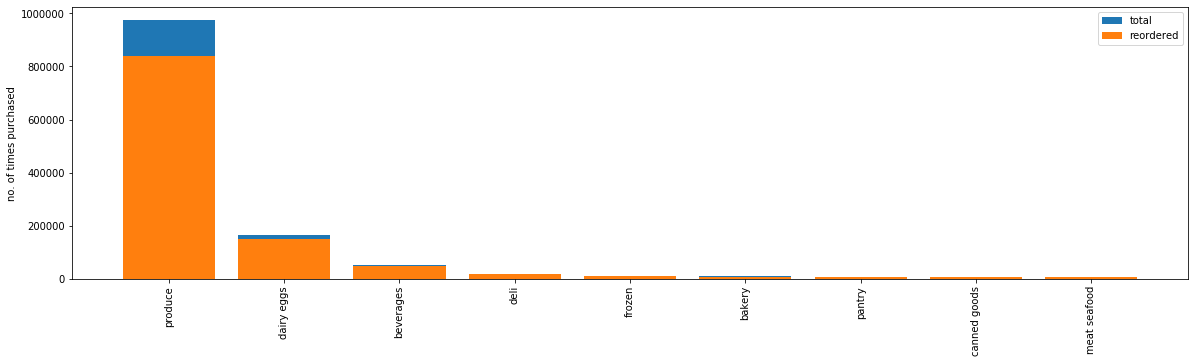

  division_name  is_reordered   total       Avg
8       produce        839166  975005  0.860679
3    dairy eggs        148104  166335  0.890396
1     beverages         46976   52044  0.902621
4          deli         16765   19586  0.855969
5        frozen          8969   11506  0.779506
  division_name  is_reordered  total       Avg
5        frozen          8969  11506  0.779506
0        bakery          8214   9083  0.904327
7        pantry          5281   7436  0.710194
2  canned goods          5170   6692  0.772564
6  meat seafood          5129   6285  0.816070


In [45]:
univariate_barplots(df_train_x_past_1, 'division_name', 'is_reordered', 20)

### 3-2. category_name(분류별)

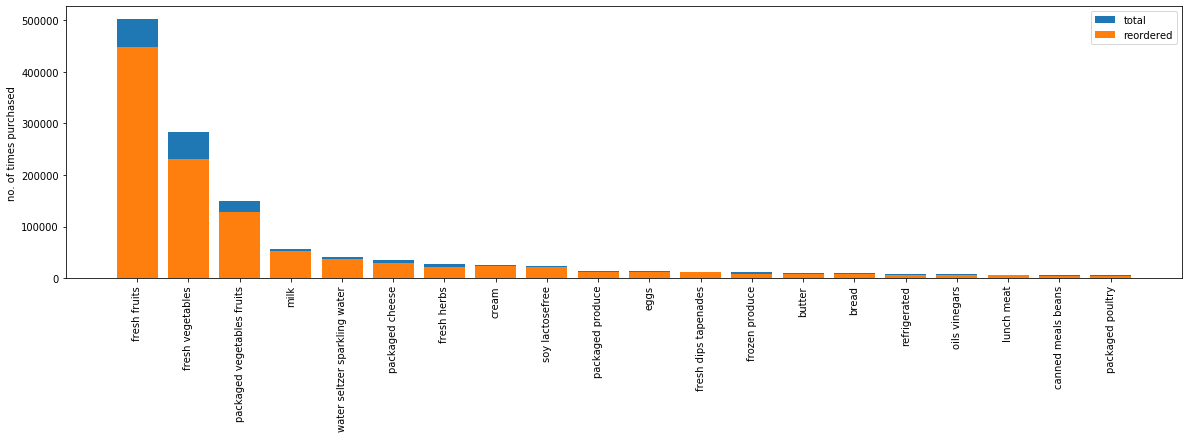

                    category_name  is_reordered   total       Avg
6                    fresh fruits        447996  501780  0.892814
8                fresh vegetables        230623  282838  0.815389
16     packaged vegetables fruits        127942  149855  0.853772
11                           milk         53388   57404  0.930040
20  water seltzer sparkling water         37430   41593  0.899911
         category_name  is_reordered  total       Avg
17        refrigerated          7007   7739  0.905414
12       oils vinegars          5281   7436  0.710194
10          lunch meat          5685   6805  0.835415
2   canned meals beans          5170   6692  0.772564
14    packaged poultry          5129   6285  0.816070


In [46]:
univariate_barplots(df_train_x_past_1, 'category_name', 'is_reordered', 20)

### 3-3. name(상품별)

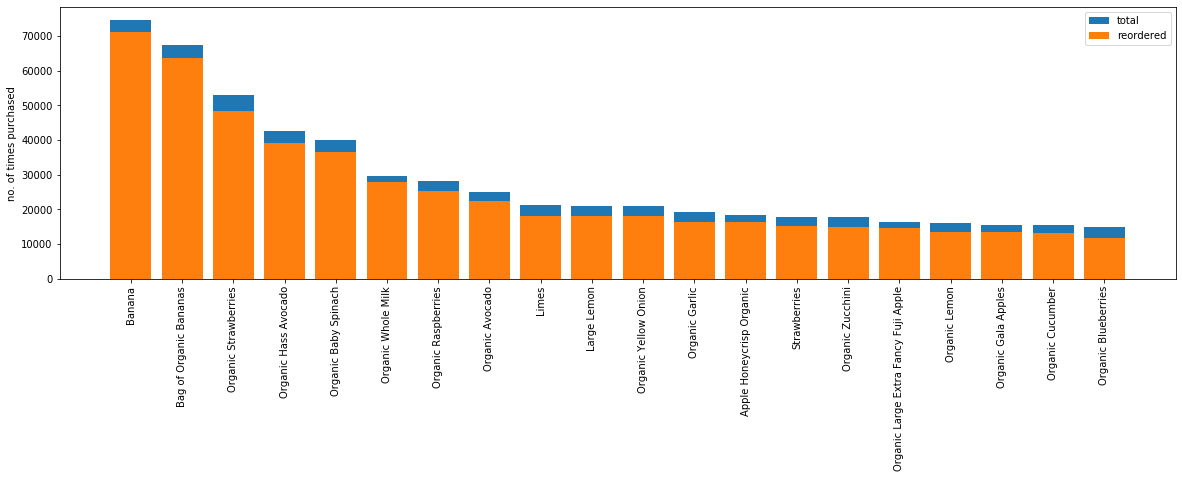

                      name  is_reordered  total       Avg
6                   Banana         71104  74686  0.952039
5   Bag of Organic Bananas         63601  67514  0.942042
71    Organic Strawberries         48516  52917  0.916832
55    Organic Hass Avocado         39136  42604  0.918599
35    Organic Baby Spinach         36444  40112  0.908556
                                    name  is_reordered  total       Avg
59  Organic Large Extra Fancy Fuji Apple         14477  16387  0.883444
60                         Organic Lemon         13579  15970  0.850282
47                   Organic Gala Apples         13599  15611  0.871117
44                      Organic Cucumber         13180  15470  0.851972
39                   Organic Blueberries         11806  14859  0.794535


In [47]:
univariate_barplots(df_train_x_past_1, 'name', 'is_reordered', 20)

### 3-4. week_day(요일별)

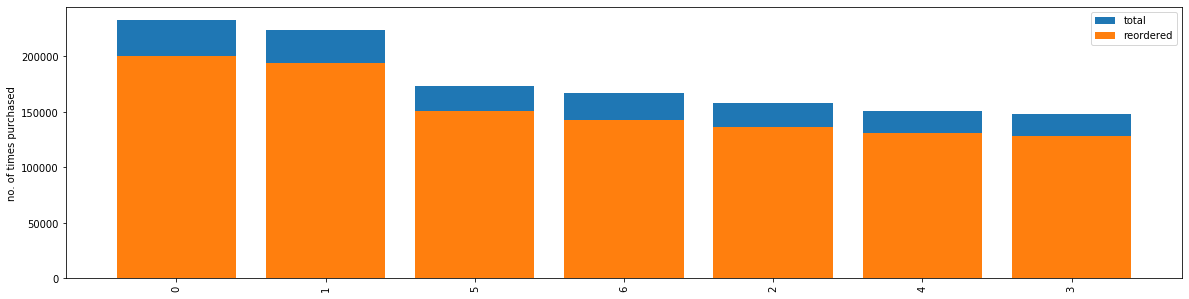

   week_day  is_reordered   total       Avg
0         0        200190  233220  0.858374
1         1        194143  223454  0.868828
5         5        151019  173503  0.870411
6         6        143050  167028  0.856443
2         2        136527  157744  0.865497
   week_day  is_reordered   total       Avg
5         5        151019  173503  0.870411
6         6        143050  167028  0.856443
2         2        136527  157744  0.865497
4         4        130842  151015  0.866417
3         3        128003  148008  0.864838


In [48]:
univariate_barplots(df_train_x_past_1, 'week_day', 'is_reordered', 20)

### 3-5. order_hour(시간별)

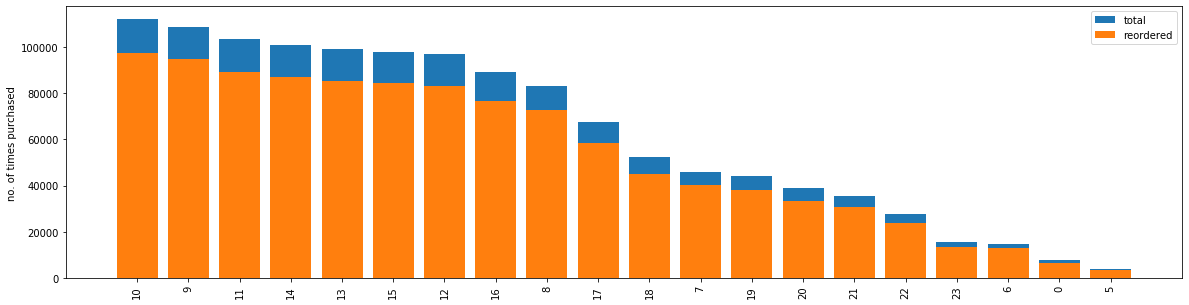

    order_hour  is_reordered   total       Avg
10          10         97116  111896  0.867913
9            9         94788  108608  0.872753
11          11         89209  103477  0.862114
14          14         86741  100804  0.860492
13          13         85382   98959  0.862802
    order_hour  is_reordered  total       Avg
22          22         23991  27839  0.861777
23          23         13312  15613  0.852623
6            6         12873  14822  0.868506
0            0          6562   7736  0.848242
5            5          3351   3861  0.867910


In [49]:
univariate_barplots(df_train_x_past_1, 'order_hour', 'is_reordered', 20)

### 3-6. order_interval(주문간격별)

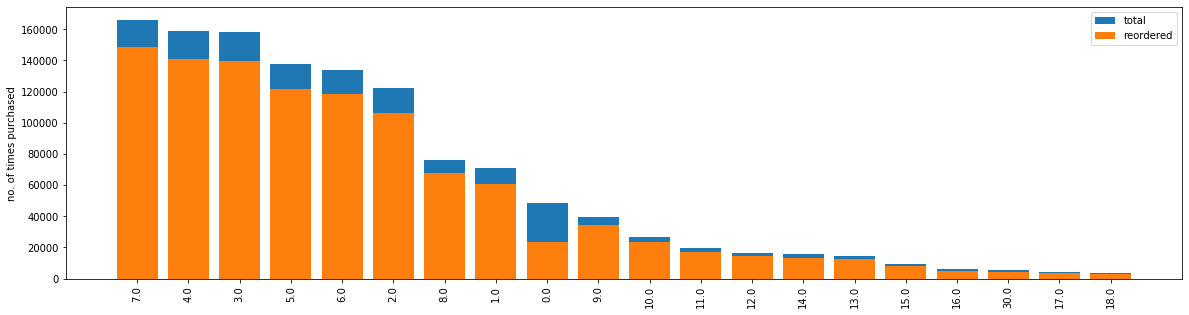

   order_interval  is_reordered   total       Avg
7             7.0        148671  166085  0.895150
4             4.0        140629  158784  0.885662
3             3.0        139403  158003  0.882281
5             5.0        121928  137831  0.884620
6             6.0        118467  134051  0.883746
    order_interval  is_reordered  total       Avg
15            15.0          8282   9532  0.868863
16            16.0          5107   6037  0.845950
30            30.0          4277   5627  0.760085
17            17.0          3831   4510  0.849446
18            18.0          3231   3788  0.852957


In [50]:
univariate_barplots(df_train_x_past_1, 'order_interval', 'is_reordered', 20)

### 3-7. add_order(장바구니 순서별)

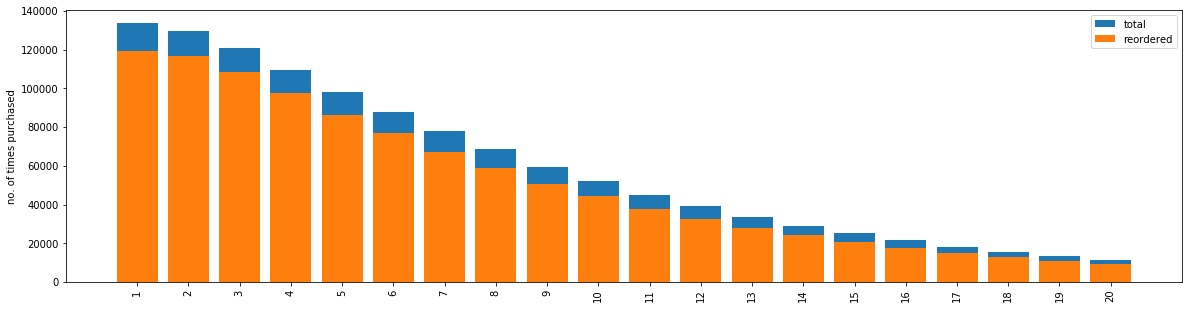

   add_order  is_reordered   total       Avg
0          1        119334  133657  0.892838
1          2        116763  129468  0.901868
2          3        108435  120717  0.898258
3          4         97480  109523  0.890041
4          5         86461   98259  0.879930
    add_order  is_reordered  total       Avg
15         16         17569  21617  0.812740
16         17         14846  18320  0.810371
17         18         12682  15706  0.807462
18         19         10898  13511  0.806602
19         20          9227  11554  0.798598


In [51]:
univariate_barplots(df_train_x_past_1, 'add_order', 'is_reordered', 20)

# Step3. 데이터 전처리 및 변수 생성

* evaluation set 구성 <br>
train_x_past & test_x_past → prior <br>
train_x_current (+train_y) → train <br>
test_x_current → test

## 1. Data Set 생성

* orders_all

In [52]:
# train_x_past (과거 데이터) eval_set : prior 로 정의
df_train_x_past = df_train_x_past.apply(pd.to_numeric, errors='coerce').fillna(0)
df_train_x_past['eval_set'] = 'prior'
df_train_x_past.tail()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,eval_set
1253967,1902783,163819,47,0,19,13.0,2,1,24852,prior
1253968,1969590,163819,42,1,15,6.0,3,1,24852,prior
1253969,2549215,163819,9,1,11,7.0,1,1,24852,prior
1253970,3103211,163819,39,1,14,7.0,3,1,24852,prior
1253971,3207262,163819,8,1,12,7.0,1,1,24852,prior


In [53]:
# test_x_past 로드
sql = 'SELECT * FROM test_x_past'
df_test_x_past = get_df(sql, schema)

In [54]:
# test_x_past (과거 데이터) eval_set : prior 로 정의
df_test_x_past = df_test_x_past.apply(pd.to_numeric, errors='coerce').fillna(0)
df_test_x_past['eval_set'] = 'prior'
df_test_x_past.tail()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,eval_set
541917,2672845,119134,39,1,14,17.0,4,1,24852,prior
541918,2731678,119134,38,5,14,3.0,4,1,24852,prior
541919,2860406,119134,9,5,9,8.0,1,1,24852,prior
541920,3252013,119134,4,5,10,7.0,2,1,24852,prior
541921,3275894,119134,16,4,10,3.0,10,1,24852,prior


In [55]:
# train_x_current 로드
sql = 'SELECT * FROM train_x_current'
df_train_x_current = get_df(sql, schema)

In [56]:
# train_y 로드
sql = 'SELECT * FROM train_y'
df_train_y = get_df(sql, schema)

In [57]:
# df_train_x_current & df_train_y df merge
df_train_x_current = pd.concat([df_train_x_current, df_train_y], axis=1)
df_train_x_current = df_train_x_current.apply(pd.to_numeric, errors='coerce').fillna(0)

In [58]:
# train_x_current (현재 데이터) eval_set : train 로 정의
df_train_x_current['eval_set'] = 'train'
df_train_x_current.tail()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,eval_set
24419,3184000,174046,100,5,7,2.0,12,1,24852,train
24420,1754722,6710,100,5,11,3.0,21,1,24852,train
24421,1076973,150840,100,0,13,0.0,18,1,24852,train
24422,1247049,99707,100,1,13,3.0,6,1,24852,train
24423,1775787,201038,100,5,9,2.0,1,1,24852,train


In [59]:
df_train_x_current.head(30)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,eval_set
0,806422,41116,47,5,18,3.0,4,1,21709,train
1,2146033,127113,45,1,10,7.0,24,1,21709,train
2,3055498,140168,45,5,10,26.0,11,1,21709,train
3,3267527,60604,52,0,16,8.0,2,1,21709,train
4,3125992,136554,46,4,9,5.0,2,0,21709,train
5,2883377,30098,45,0,15,13.0,19,0,21709,train
6,879062,138549,50,5,16,7.0,4,1,21709,train
7,3234080,42711,100,1,9,5.0,11,1,21709,train
8,2026101,114720,44,0,20,6.0,2,1,21709,train
9,1732236,182942,49,0,15,21.0,2,1,21709,train


In [62]:
orders_all = pd.concat([df_train_x_past, df_test_x_past, df_train_x_current], ignore_index=True)
orders_all = orders_all.sort_values(by=['cstno','order_number','add_order'])
orders_all

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,eval_set
1695,3131103,50,2,6,12,10.0,3,0,21137,prior
1676,2197066,50,3,1,13,9.0,2,0,47209,prior
1657,3201640,50,4,0,11,6.0,5,0,24964,prior
1613,2756806,50,5,4,14,11.0,6,0,34126,prior
1622,1941871,50,9,4,11,5.0,1,0,41950,prior
...,...,...,...,...,...,...,...,...,...,...
1308924,619826,206193,40,4,10,3.0,5,1,15290,prior
1306142,619826,206193,40,4,10,3.0,7,0,46906,prior
1743452,452589,206193,41,0,15,3.0,12,1,13176,prior
1567698,452589,206193,41,0,15,3.0,13,1,5876,prior


* 주문번호가 연결되어 있지 않기 때문에(2,3,4,7,9,...) 주문번호 row 적재 순서대로 새로운 번호 생성 (1,2,3...)
* rank 함수 사용

In [63]:
# 고객번호별 새로운 주문번호 생성 : 주문번호 row 존재순서대로 (1,2,3,4...)
# 그룹별 랭킹 사용.
# method = 'dense' : 동순위는 동일한 rank 부여 (단, 다음 rank 값은 무조건 1씩 증가 --- 1등이 2명이라고 해서 3번째는 3등이 아닌 2등으로 표시됨)
# method = 'first' : 동순위 내에서 row 표시되는 순서대로 순위부여 (공동 등수라면 데이터 적재된 순서대로 순위부여)
orders_all['order_number_new'] = orders_all.groupby('cstno')['order_number'].rank(method='dense', ascending=True) 

In [64]:
# order_number로 컬럼 변경 (기존 order_number 삭제후 , _new를 order_number로 컬럼명변경)
orders_all = orders_all.drop('order_number', axis=1).rename(columns={'order_number_new' : 'order_number'})
orders_all.head(10)

,order_id,cstno,week_day,order_hour,order_interval,add_order,is_reordered,product_id,eval_set,order_number
1695,3131103,50,6,12,10.0,3,0,21137,prior,1.0
1676,2197066,50,1,13,9.0,2,0,47209,prior,2.0
1657,3201640,50,0,11,6.0,5,0,24964,prior,3.0
1613,2756806,50,4,14,11.0,6,0,34126,prior,4.0
1622,1941871,50,4,11,5.0,1,0,41950,prior,5.0
1694,1941871,50,4,11,5.0,4,1,21137,prior,5.0
1612,1941871,50,4,11,5.0,5,1,34126,prior,5.0
1693,1431607,50,2,10,5.0,1,1,21137,prior,6.0
1670,771250,50,3,18,4.0,3,1,47209,prior,7.0
1607,771250,50,3,18,4.0,5,1,34126,prior,7.0


* 고객에 대한 정보만 보기 위해 상품정보 제거하고 중복제거한 orders df 생성 (orders_all 에서 고객별, 주문번호별 중복제거)

In [65]:
orders = orders_all.drop(['product_id', 'add_order','is_reordered'], axis=1)
orders = orders.drop_duplicates(['cstno','order_number'],keep='last')
orders

,order_id,cstno,week_day,order_hour,order_interval,eval_set,order_number
1695,3131103,50,6,12,10.0,prior,1.0
1676,2197066,50,1,13,9.0,prior,2.0
1657,3201640,50,0,11,6.0,prior,3.0
1613,2756806,50,4,14,11.0,prior,4.0
1612,1941871,50,4,11,5.0,prior,5.0
...,...,...,...,...,...,...,...
1641400,1765908,206193,0,12,2.0,prior,34.0
1743465,1627747,206193,5,11,5.0,prior,35.0
1685316,85598,206193,1,16,3.0,prior,36.0
1306142,619826,206193,4,10,3.0,prior,37.0


In [66]:
# eval set 확인
orders_all['eval_set'].value_counts()

prior    1795894
train      24424
Name: eval_set, dtype: int64

In [67]:
# 결측치 확인
orders.isnull().sum()

order_id          0
cstno             0
week_day          0
order_hour        0
order_interval    0
eval_set          0
order_number      0
dtype: int64

In [68]:
# test_x_current 로드
sql = 'SELECT * FROM test_x_current'
test_x_current = get_df(sql, schema)

In [69]:
# 필요컬럼만 남기고 고객별, 주문별로 중복제거
test_x_current = test_x_current.drop(['add_order','is_reordered'], axis=1)
test_x_current = test_x_current.drop_duplicates(['cstno','order_number'],keep='last')

# test_x_current (예측해야할 데이터) eval_set : test 로 정의
test_x_current['eval_set'] = 'test'
test_x_current.tail()

,order_id,cstno,order_number,week_day,order_hour,order_interval,eval_set
16121,2047884,57077,46,5,15,8.0,test
16122,567625,83592,43,4,12,0.0,test
16123,596442,157740,49,6,10,3.0,test
16124,671102,92043,43,4,10,10.0,test
16125,529654,62871,58,4,8,8.0,test


In [70]:
# orders와 test_x_current Merge
orders = pd.concat([orders, test_x_current], ignore_index=True)
orders

,order_id,cstno,week_day,order_hour,order_interval,eval_set,order_number
0,3131103,50,6,12,10,prior,1
1,2197066,50,1,13,9,prior,2
2,3201640,50,0,11,6,prior,3
3,2756806,50,4,14,11,prior,4
4,1941871,50,4,11,5,prior,5
...,...,...,...,...,...,...,...
508362,2047884,57077,5,15,8.0,test,46
508363,567625,83592,4,12,0.0,test,43
508364,596442,157740,6,10,3.0,test,49
508365,671102,92043,4,10,10.0,test,43


In [71]:
# eval_set : prior 인 prior_orders df 생성
prior_orders = orders_all[orders_all['eval_set']=='prior']
prior_orders

,order_id,cstno,week_day,order_hour,order_interval,add_order,is_reordered,product_id,eval_set,order_number
1695,3131103,50,6,12,10.0,3,0,21137,prior,1.0
1676,2197066,50,1,13,9.0,2,0,47209,prior,2.0
1657,3201640,50,0,11,6.0,5,0,24964,prior,3.0
1613,2756806,50,4,14,11.0,6,0,34126,prior,4.0
1622,1941871,50,4,11,5.0,1,0,41950,prior,5.0
...,...,...,...,...,...,...,...,...,...,...
1308924,619826,206193,4,10,3.0,5,1,15290,prior,37.0
1306142,619826,206193,4,10,3.0,7,0,46906,prior,37.0
1743452,452589,206193,0,15,3.0,12,1,13176,prior,38.0
1567698,452589,206193,0,15,3.0,13,1,5876,prior,38.0


In [72]:
# 주문별 상품별 order_products_prior df 생성
order_products_prior = prior_orders[['order_id','product_id','add_order','is_reordered']]
order_products_prior

,order_id,product_id,add_order,is_reordered
1695,3131103,21137,3,0
1676,2197066,47209,2,0
1657,3201640,24964,5,0
1613,2756806,34126,6,0
1622,1941871,41950,1,0
...,...,...,...,...
1308924,619826,15290,5,1
1306142,619826,46906,7,0
1743452,452589,13176,12,1
1567698,452589,5876,13,1


In [73]:
# eval_set : train 인 prior_orders df 생성
train_orders = orders_all[orders_all['eval_set']=='train']
train_orders

,order_id,cstno,week_day,order_hour,order_interval,add_order,is_reordered,product_id,eval_set,order_number
1815322,1750084,50,3,9,7.0,2,1,47209,train,52.0
1818132,1750084,50,3,9,7.0,3,1,13176,train,52.0
1816051,1750084,50,3,9,7.0,5,1,21903,train,52.0
1813161,2560500,140,4,21,2.0,3,1,27845,train,69.0
1818619,2560500,140,4,21,2.0,4,1,13176,train,69.0
...,...,...,...,...,...,...,...,...,...,...
1806361,1459121,206035,5,12,7.0,24,0,30489,train,57.0
1802259,1459121,206035,5,12,7.0,26,1,43961,train,57.0
1813534,395225,206053,4,17,3.0,2,1,26209,train,57.0
1812512,395225,206053,4,17,3.0,6,1,27966,train,57.0


In [74]:
# 주문별 상품별 order_products_train df 생성
order_products_train = train_orders[['order_id','product_id','add_order','is_reordered']]
order_products_train

,order_id,product_id,add_order,is_reordered
1815322,1750084,47209,2,1
1818132,1750084,13176,3,1
1816051,1750084,21903,5,1
1813161,2560500,27845,3,1
1818619,2560500,13176,4,1
...,...,...,...,...
1806361,1459121,30489,24,0
1802259,1459121,43961,26,1
1813534,395225,26209,2,1
1812512,395225,27966,6,1


In [75]:
# 데이터 가공을 위한 타입 변경
orders['order_id'] = orders['order_id'].astype(int)
orders['cstno'] = orders['cstno'].astype(int)
orders['order_number'] = orders['order_number'].astype(int)
orders['week_day'] = orders['week_day'].astype(int)
orders['order_hour'] = orders['order_hour'].astype(int)
orders['order_interval'] = orders['order_interval'].astype(float)

## 2. 변수 생성 - 고객별

In [76]:
# 과거 데이터를 이용한 고객별 변수 생성
# 고객이 총 주문한 횟수
cst = prior_orders.groupby(by='cstno')['order_number'].aggregate('max').to_frame('cst_tot_OrderN').reset_index()
cst

,cstno,cst_tot_OrderN
0,50,51.0
1,63,35.0
2,140,68.0
3,142,41.0
4,173,37.0
...,...,...
9995,206083,36.0
9996,206117,40.0
9997,206124,44.0
9998,206174,41.0


In [77]:
# 고객이 총 주문한 상품 수
cst_tot_productN_per_order = prior_orders.groupby(by=['cstno', 'order_id'])['product_id'].aggregate('count').to_frame('cst_tot_productN_per_order').reset_index()
cst_tot_productN_per_order

,cstno,order_id,cst_tot_productN_per_order
0,50,103726,4
1,50,131991,1
2,50,182020,6
3,50,218647,1
4,50,309687,3
...,...,...,...
498362,206193,1997208,1
498363,206193,2155927,3
498364,206193,2503842,3
498365,206193,2784188,1


In [78]:
# 고객이 한번 주문할때 평균 주문하는 상품 수
cst_avg_productN_per_order = cst_tot_productN_per_order.groupby(by=['cstno'])['cst_tot_productN_per_order'].mean().to_frame('cst_avg_productN_per_order').reset_index()
cst_avg_productN_per_order.head()

,cstno,cst_avg_productN_per_order
0,50,2.803922
1,63,3.228571
2,140,4.323529
3,142,3.292683
4,173,3.081081


In [79]:
# Scipy (Scientific + Python) 활용
# Import scipy
from scipy import stats

# 고객이 가장 많이 주문한 요일
order_most_weekd = prior_orders.groupby(by=['cstno'])['week_day'].aggregate(lambda x : stats.mode(x)[0]).to_frame('cst_most_weekd').reset_index()
order_most_weekd.head()

,cstno,cst_most_weekd
0,50,1
1,63,1
2,140,4
3,142,5
4,173,2


In [80]:
# 고객이 가장 많이 주문한 시간
order_most_hour = prior_orders.groupby(by=['cstno'])['order_hour'].aggregate(lambda x : stats.mode(x)[0]).to_frame('cst_most_hour').reset_index()
order_most_hour.head()

,cstno,cst_most_hour
0,50,11
1,63,12
2,140,10
3,142,14
4,173,10


In [81]:
# 고객이 가장 많이 주문한 주문간격
order_most_interval = prior_orders.groupby(by=['cstno'])['order_interval'].aggregate(lambda x : stats.mode(x)[0]).to_frame('cst_most_interval').reset_index()
order_most_interval.head()

,cstno,cst_most_interval
0,50,4.0
1,63,5.0
2,140,5.0
3,142,4.0
4,173,5.0


In [82]:
# 고객별 재구매비율
cst_reorder_ratio = prior_orders.groupby(by='cstno')['is_reordered'].aggregate('mean').to_frame('cst_reorder_ratio').reset_index()
cst_reorder_ratio['cst_reorder_ratio'] = cst_reorder_ratio['cst_reorder_ratio'].astype(np.float16)
cst_reorder_ratio.head()

,cstno,cst_reorder_ratio
0,50,0.853027
1,63,0.796387
2,140,0.843750
3,142,0.829590
4,173,0.728027


In [83]:
# 고객별 df merge
cst = cst.merge(cst_avg_productN_per_order, on='cstno', how='left')
cst = cst.merge(order_most_weekd, on='cstno', how='left')
cst = cst.merge(order_most_hour, on='cstno', how='left')
cst = cst.merge(cst_reorder_ratio, on='cstno', how='left')

cst.head()

,cstno,cst_tot_OrderN,cst_avg_productN_per_order,cst_most_weekd,cst_most_hour,cst_reorder_ratio
0,50,51.0,2.803922,1,11,0.853027
1,63,35.0,3.228571,1,12,0.796387
2,140,68.0,4.323529,4,10,0.843750
3,142,41.0,3.292683,5,14,0.829590
4,173,37.0,3.081081,2,10,0.728027


## 3. 변수 생성 - 상품별

In [84]:
# 상품별 전체 주문 횟수
prod_N = prior_orders.groupby(by='product_id')['order_id'].aggregate('count').to_frame('prod_N').reset_index()
prod_N.head()

,product_id,prod_N
0,196,4953
1,3957,10984
2,4210,7402
3,4605,12672
4,4799,9584


In [85]:
# 각 상품별 재구매 비율
prod_ReorderRatio = prior_orders.groupby(by='product_id')['is_reordered'].aggregate('mean').to_frame('prod_ReorderRatio').reset_index()
prod_ReorderRatio.head()

,product_id,prod_ReorderRatio
0,196,0.930143
1,3957,0.898580
2,4210,0.901648
3,4605,0.755840
4,4799,0.795597


In [86]:
# 각 상품별 평균 장바구니에 담긴 순서
prod_AddOrder = prior_orders.groupby(by='product_id')['add_order'].aggregate('mean').to_frame('prod_AddOrder').reset_index()
prod_AddOrder.head()

,product_id,prod_AddOrder
0,196,3.895619
1,3957,6.558449
2,4210,4.846528
3,4605,8.888889
4,4799,9.229967


In [87]:
# 상품별 df merge
prod = prod_N.merge(prod_ReorderRatio, on='product_id', how='left')
prod = prod.merge(prod_AddOrder, on='product_id', how='left')
prod.head()

,product_id,prod_N,prod_ReorderRatio,prod_AddOrder
0,196,4953,0.930143,3.895619
1,3957,10984,0.898580,6.558449
2,4210,7402,0.901648,4.846528
3,4605,12672,0.755840,8.888889
4,4799,9584,0.795597,9.229967


## 4. 변수 생성 - 고객별&상품별

In [88]:
# 고객이 해당 상품을 주문한 횟수
pc_N = prior_orders.groupby(by=['cstno', 'product_id'])['order_id'].aggregate('count').to_frame('pc_N').reset_index()
pc_N.head()

,cstno,product_id,pc_N
0,50,5785,1
1,50,5876,3
2,50,8518,2
3,50,9839,4
4,50,13176,17


In [89]:
# 고객이 해당상품을 처음 주문할때 상품의 주문번호
pc_first_order_No = prior_orders.groupby(by=['cstno', 'product_id'])['order_number'].aggregate('min').to_frame('pc_first_order_No').reset_index()
pc_first_order_No.head()

,cstno,product_id,pc_first_order_No
0,50,5785,43.0
1,50,5876,26.0
2,50,8518,11.0
3,50,9839,31.0
4,50,13176,29.0


In [90]:
# 고객별 주문횟수
pc_tot_orderN = prior_orders.groupby('cstno')['order_number'].max().to_frame('pc_tot_orderN').reset_index()
pc_tot_orderN.head()

,cstno,pc_tot_orderN
0,50,51.0
1,63,35.0
2,140,68.0
3,142,41.0
4,173,37.0


In [91]:
pc_df = pd.merge(pc_tot_orderN, pc_first_order_No, on='cstno', how='right')
pc_df.head()

,cstno,pc_tot_orderN,product_id,pc_first_order_No
0,50,51.0,5785,43.0
1,50,51.0,5876,26.0
2,50,51.0,8518,11.0
3,50,51.0,9839,31.0
4,50,51.0,13176,29.0


In [92]:
pc_df['pc_order_range'] = pc_df['pc_tot_orderN'] - pc_df['pc_first_order_No'] + 1
pc_df.head()

,cstno,pc_tot_orderN,product_id,pc_first_order_No,pc_order_range
0,50,51.0,5785,43.0,9.0
1,50,51.0,5876,26.0,26.0
2,50,51.0,8518,11.0,41.0
3,50,51.0,9839,31.0,21.0
4,50,51.0,13176,29.0,23.0


In [93]:
# pc_N 과 pc_df Merge
pc_ratio = pd.merge(pc_N, pc_df, on=['cstno', 'product_id'], how='left')
pc_ratio.head()

,cstno,product_id,pc_N,pc_tot_orderN,pc_first_order_No,pc_order_range
0,50,5785,1,51.0,43.0,9.0
1,50,5876,3,51.0,26.0,26.0
2,50,8518,2,51.0,11.0,41.0
3,50,9839,4,51.0,31.0,21.0
4,50,13176,17,51.0,29.0,23.0


In [94]:
# 각 상품별 재구매율 계산
pc_ratio['pc_reorder_ratio'] = pc_ratio['pc_N'] / pc_ratio['pc_order_range']
pc_ratio.head()

,cstno,product_id,pc_N,pc_tot_orderN,pc_first_order_No,pc_order_range,pc_reorder_ratio
0,50,5785,1,51.0,43.0,9.0,0.111111
1,50,5876,3,51.0,26.0,26.0,0.115385
2,50,8518,2,51.0,11.0,41.0,0.048780
3,50,9839,4,51.0,31.0,21.0,0.190476
4,50,13176,17,51.0,29.0,23.0,0.739130


In [95]:
# 필요 없는 컬럼 삭제
pc_ratio.drop(['pc_N', 'pc_tot_orderN', 'pc_first_order_No', 'pc_order_range'], axis=1, inplace=True)
pc_ratio.head()

,cstno,product_id,pc_reorder_ratio
0,50,5785,0.111111
1,50,5876,0.115385
2,50,8518,0.048780
3,50,9839,0.190476
4,50,13176,0.739130


In [96]:
# 고객별 상품별 df merge
pc_N = pc_N.merge(pc_ratio, on=['cstno', 'product_id'], how='left')
pc_N.head()

,cstno,product_id,pc_N,pc_reorder_ratio
0,50,5785,1,0.111111
1,50,5876,3,0.115385
2,50,8518,2,0.048780
3,50,9839,4,0.190476
4,50,13176,17,0.739130


In [97]:
# max값 생성 하면서 변수 생성  
prior_orders['order_number_back'] = prior_orders.groupby(by=['cstno'])['order_number'].transform(max) - prior_orders['order_number'] +1
prior_orders.head()

/opt/conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,order_id,cstno,week_day,order_hour,order_interval,add_order,is_reordered,product_id,eval_set,order_number,order_number_back
1695,3131103,50,6,12,10.0,3,0,21137,prior,1.0,51.0
1676,2197066,50,1,13,9.0,2,0,47209,prior,2.0,50.0
1657,3201640,50,0,11,6.0,5,0,24964,prior,3.0,49.0
1613,2756806,50,4,14,11.0,6,0,34126,prior,4.0,48.0
1622,1941871,50,4,11,5.0,1,0,41950,prior,5.0,47.0


In [98]:
# 최근 3개 주문 확인
temp_df = prior_orders.loc[prior_orders.order_number_back <= 3]
temp_df.head()

,order_id,cstno,week_day,order_hour,order_interval,add_order,is_reordered,product_id,eval_set,order_number,order_number_back
1587,2740653,50,1,13,6.0,3,1,22825,prior,49.0,3.0
1574,2740653,50,1,13,6.0,4,1,9839,prior,49.0,3.0
1707,2107003,50,4,11,3.0,1,1,13176,prior,50.0,2.0
1625,2107003,50,4,11,3.0,2,1,41950,prior,50.0,2.0
1663,2107003,50,4,11,3.0,6,1,22935,prior,50.0,2.0


In [99]:
# 고객의 해당 상품 주문 최근 3개
last_three_order = temp_df.groupby(by=['cstno', 'product_id'])['order_id'].aggregate('count').to_frame('pc_last_three').reset_index()
last_three_order.head()

,cstno,product_id,pc_last_three
0,50,9839,1
1,50,13176,2
2,50,21903,1
3,50,22825,2
4,50,22935,1


In [100]:
# 최근 주문 3개의 비율
last_three_order['pc_ratio_last_three'] = last_three_order['pc_last_three'] / 3
last_three_order.head()

,cstno,product_id,pc_last_three,pc_ratio_last_three
0,50,9839,1,0.333333
1,50,13176,2,0.666667
2,50,21903,1,0.333333
3,50,22825,2,0.666667
4,50,22935,1,0.333333


In [101]:
# 고객이 해당상품을 주문할때 장바구니에 담는 평균 순서
pc_avg_add_order = prior_orders.groupby(by=['cstno', 'product_id'])['add_order'].aggregate('mean').to_frame('pc_avg_add_order').reset_index()
pc_avg_add_order.head()

,cstno,product_id,pc_avg_add_order
0,50,5785,3.000000
1,50,5876,6.333333
2,50,8518,8.000000
3,50,9839,5.000000
4,50,13176,1.941176


In [102]:
# 고객별 & 상품별 df 에 최근 주문 3개 Merge
pc_df_f = pc_N.merge(last_three_order, on=['cstno', 'product_id'], how='left')

In [103]:
pc_df_f = pc_df_f.merge(pc_avg_add_order, on=['cstno', 'product_id'], how='left')
pc_df_f.head()

,cstno,product_id,pc_N,pc_reorder_ratio,pc_last_three,pc_ratio_last_three,pc_avg_add_order
0,50,5785,1,0.111111,NaN,NaN,3.000000
1,50,5876,3,0.115385,NaN,NaN,6.333333
2,50,8518,2,0.048780,NaN,NaN,8.000000
3,50,9839,4,0.190476,1.0,0.333333,5.000000
4,50,13176,17,0.739130,2.0,0.666667,1.941176


In [104]:
# 결측치 확인
pc_df_f.isnull().sum()

cstno                       0
product_id                  0
pc_N                        0
pc_reorder_ratio            0
pc_last_three          188337
pc_ratio_last_three    188337
pc_avg_add_order            0
dtype: int64

In [105]:
# 결측치 채우기
pc_df_f.fillna(0, inplace=True)
pc_df_f.isnull().sum()                         

cstno                  0
product_id             0
pc_N                   0
pc_reorder_ratio       0
pc_last_three          0
pc_ratio_last_three    0
pc_avg_add_order       0
dtype: int64

# Step4. Feature Engineering

## 1. Feature Engineering df 생성

In [106]:
#  고객별&상품별 df, 고객별 df, 상품별 df Merge
fe_df = pc_df_f.merge(cst, on='cstno', how='left')
fe_df = fe_df.merge(prod, on='product_id', how='left')
fe_df.head()

,cstno,product_id,pc_N,pc_reorder_ratio,pc_last_three,pc_ratio_last_three,pc_avg_add_order,cst_tot_OrderN,cst_avg_productN_per_order,cst_most_weekd,cst_most_hour,cst_reorder_ratio,prod_N,prod_ReorderRatio,prod_AddOrder
0,50,5785,1,0.111111,0.0,0.000000,3.000000,51.0,2.803922,1,11,0.853027,13691,0.911986,6.046016
1,50,5876,3,0.115385,0.0,0.000000,6.333333,51.0,2.803922,1,11,0.853027,22434,0.833690,8.244495
2,50,8518,2,0.048780,0.0,0.000000,8.000000,51.0,2.803922,1,11,0.853027,15898,0.767392,9.619763
3,50,9839,4,0.190476,1.0,0.333333,5.000000,51.0,2.803922,1,11,0.853027,9503,0.848995,8.547827
4,50,13176,17,0.739130,2.0,0.666667,1.941176,51.0,2.803922,1,11,0.853027,96600,0.934058,5.320797


In [107]:
# 결측치 확인
fe_df.isnull().sum()

cstno                         0
product_id                    0
pc_N                          0
pc_reorder_ratio              0
pc_last_three                 0
pc_ratio_last_three           0
pc_avg_add_order              0
cst_tot_OrderN                0
cst_avg_productN_per_order    0
cst_most_weekd                0
cst_most_hour                 0
cst_reorder_ratio             0
prod_N                        0
prod_ReorderRatio             0
prod_AddOrder                 0
dtype: int64

## 2. Final Dataset 생성

In [108]:
# orders 데이터 확인
orders

,order_id,cstno,week_day,order_hour,order_interval,eval_set,order_number
0,3131103,50,6,12,10.0,prior,1
1,2197066,50,1,13,9.0,prior,2
2,3201640,50,0,11,6.0,prior,3
3,2756806,50,4,14,11.0,prior,4
4,1941871,50,4,11,5.0,prior,5
...,...,...,...,...,...,...,...
508362,2047884,57077,5,15,8.0,test,46
508363,567625,83592,4,12,0.0,test,43
508364,596442,157740,6,10,3.0,test,49
508365,671102,92043,4,10,10.0,test,43


In [109]:
# orders 데이터 확인
orders['eval_set'].value_counts()

prior    498367
train      5859
test       4141
Name: eval_set, dtype: int64

In [110]:
# 미래 주문
orders_future = orders[((orders.eval_set=='train') | (orders.eval_set=='test'))]
orders_future = orders_future[['cstno', 'eval_set', 'order_id']]
orders_future['order_id'] = orders_future['order_id'].astype(int)
orders_future['cstno'] = orders_future['cstno'].astype(int)

In [111]:
# cstno, eval_set 기준으로 정렬
orders_future.sort_values(['cstno','eval_set'])
orders_future

,cstno,eval_set,order_id
51,50,train,1750084
155,140,train,2560500
284,204,train,1447810
383,210,train,3176785
426,223,train,180627
...,...,...,...
508362,57077,test,2047884
508363,83592,test,567625
508364,157740,test,596442
508365,92043,test,671102


In [112]:
# 최종 데이터 생성 (feature engineering, orders_future Merge)
final_data = fe_df.merge(orders_future, on='cstno', how='left')
final_data

,cstno,product_id,pc_N,pc_reorder_ratio,pc_last_three,pc_ratio_last_three,pc_avg_add_order,cst_tot_OrderN,cst_avg_productN_per_order,cst_most_weekd,cst_most_hour,cst_reorder_ratio,prod_N,prod_ReorderRatio,prod_AddOrder,eval_set,order_id
0,50,5785,1,0.111111,0.0,0.000000,3.000000,51.0,2.803922,1,11,0.853027,13691,0.911986,6.046016,train,1750084
1,50,5876,3,0.115385,0.0,0.000000,6.333333,51.0,2.803922,1,11,0.853027,22434,0.833690,8.244495,train,1750084
2,50,8518,2,0.048780,0.0,0.000000,8.000000,51.0,2.803922,1,11,0.853027,15898,0.767392,9.619763,train,1750084
3,50,9839,4,0.190476,1.0,0.333333,5.000000,51.0,2.803922,1,11,0.853027,9503,0.848995,8.547827,train,1750084
4,50,13176,17,0.739130,2.0,0.666667,1.941176,51.0,2.803922,1,11,0.853027,96600,0.934058,5.320797,train,1750084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268396,206193,44359,3,0.107143,0.0,0.000000,6.666667,38.0,2.421053,1,9,0.739258,17183,0.779608,9.288192,test,2518868
268397,206193,45007,1,0.100000,0.0,0.000000,7.000000,38.0,2.421053,1,9,0.739258,25919,0.827733,9.268567,test,2518868
268398,206193,46906,1,0.500000,1.0,0.333333,7.000000,38.0,2.421053,1,9,0.739258,10078,0.794602,8.748760,test,2518868
268399,206193,47209,7,0.250000,1.0,0.333333,10.285714,38.0,2.421053,1,9,0.739258,58841,0.907361,6.996822,test,2518868


In [113]:
# cstno, eval_set 기준으로 정렬
final_data.sort_values(['cstno','eval_set'])
final_data

,cstno,product_id,pc_N,pc_reorder_ratio,pc_last_three,pc_ratio_last_three,pc_avg_add_order,cst_tot_OrderN,cst_avg_productN_per_order,cst_most_weekd,cst_most_hour,cst_reorder_ratio,prod_N,prod_ReorderRatio,prod_AddOrder,eval_set,order_id
0,50,5785,1,0.111111,0.0,0.000000,3.000000,51.0,2.803922,1,11,0.853027,13691,0.911986,6.046016,train,1750084
1,50,5876,3,0.115385,0.0,0.000000,6.333333,51.0,2.803922,1,11,0.853027,22434,0.833690,8.244495,train,1750084
2,50,8518,2,0.048780,0.0,0.000000,8.000000,51.0,2.803922,1,11,0.853027,15898,0.767392,9.619763,train,1750084
3,50,9839,4,0.190476,1.0,0.333333,5.000000,51.0,2.803922,1,11,0.853027,9503,0.848995,8.547827,train,1750084
4,50,13176,17,0.739130,2.0,0.666667,1.941176,51.0,2.803922,1,11,0.853027,96600,0.934058,5.320797,train,1750084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268396,206193,44359,3,0.107143,0.0,0.000000,6.666667,38.0,2.421053,1,9,0.739258,17183,0.779608,9.288192,test,2518868
268397,206193,45007,1,0.100000,0.0,0.000000,7.000000,38.0,2.421053,1,9,0.739258,25919,0.827733,9.268567,test,2518868
268398,206193,46906,1,0.500000,1.0,0.333333,7.000000,38.0,2.421053,1,9,0.739258,10078,0.794602,8.748760,test,2518868
268399,206193,47209,7,0.250000,1.0,0.333333,10.285714,38.0,2.421053,1,9,0.739258,58841,0.907361,6.996822,test,2518868


In [114]:
# final_data df 정보 확인
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268401 entries, 0 to 268400
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   cstno                       268401 non-null  int64  
 1   product_id                  268401 non-null  int64  
 2   pc_N                        268401 non-null  int64  
 3   pc_reorder_ratio            268401 non-null  float64
 4   pc_last_three               268401 non-null  float64
 5   pc_ratio_last_three         268401 non-null  float64
 6   pc_avg_add_order            268401 non-null  float64
 7   cst_tot_OrderN              268401 non-null  float64
 8   cst_avg_productN_per_order  268401 non-null  float64
 9   cst_most_weekd              268401 non-null  int64  
 10  cst_most_hour               268401 non-null  int64  
 11  cst_reorder_ratio           268401 non-null  float16
 12  prod_N                      268401 non-null  int64  
 13  prod_ReorderRa

## 3. Train / Test Dataset 생성

### 3-1. Train Dataset

In [115]:
train_data = final_data[final_data.eval_set=='train']
train_data

,cstno,product_id,pc_N,pc_reorder_ratio,pc_last_three,pc_ratio_last_three,pc_avg_add_order,cst_tot_OrderN,cst_avg_productN_per_order,cst_most_weekd,cst_most_hour,cst_reorder_ratio,prod_N,prod_ReorderRatio,prod_AddOrder,eval_set,order_id
0,50,5785,1,0.111111,0.0,0.000000,3.000000,51.0,2.803922,1,11,0.853027,13691,0.911986,6.046016,train,1750084
1,50,5876,3,0.115385,0.0,0.000000,6.333333,51.0,2.803922,1,11,0.853027,22434,0.833690,8.244495,train,1750084
2,50,8518,2,0.048780,0.0,0.000000,8.000000,51.0,2.803922,1,11,0.853027,15898,0.767392,9.619763,train,1750084
3,50,9839,4,0.190476,1.0,0.333333,5.000000,51.0,2.803922,1,11,0.853027,9503,0.848995,8.547827,train,1750084
4,50,13176,17,0.739130,2.0,0.666667,1.941176,51.0,2.803922,1,11,0.853027,96600,0.934058,5.320797,train,1750084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268342,206124,28199,7,0.159091,0.0,0.000000,1.571429,44.0,1.704545,1,8,0.853516,8913,0.754067,9.064961,train,802778
268343,206124,39275,9,0.209302,0.0,0.000000,5.888889,44.0,1.704545,1,8,0.853516,21599,0.780268,8.587805,train,802778
268344,206124,43352,1,0.033333,0.0,0.000000,6.000000,44.0,1.704545,1,8,0.853516,10215,0.825649,7.000489,train,802778
268345,206124,47144,7,0.304348,2.0,0.666667,3.714286,44.0,1.704545,1,8,0.853516,6633,0.865672,6.378109,train,802778


In [116]:
train_data = train_data.merge(order_products_train[['product_id', 'order_id', 'is_reordered']], on=['product_id', 'order_id'], how='left')
train_data

,cstno,product_id,pc_N,pc_reorder_ratio,pc_last_three,pc_ratio_last_three,pc_avg_add_order,cst_tot_OrderN,cst_avg_productN_per_order,cst_most_weekd,cst_most_hour,cst_reorder_ratio,prod_N,prod_ReorderRatio,prod_AddOrder,eval_set,order_id,is_reordered
0,50,5785,1,0.111111,0.0,0.000000,3.000000,51.0,2.803922,1,11,0.853027,13691,0.911986,6.046016,train,1750084,NaN
1,50,5876,3,0.115385,0.0,0.000000,6.333333,51.0,2.803922,1,11,0.853027,22434,0.833690,8.244495,train,1750084,NaN
2,50,8518,2,0.048780,0.0,0.000000,8.000000,51.0,2.803922,1,11,0.853027,15898,0.767392,9.619763,train,1750084,NaN
3,50,9839,4,0.190476,1.0,0.333333,5.000000,51.0,2.803922,1,11,0.853027,9503,0.848995,8.547827,train,1750084,NaN
4,50,13176,17,0.739130,2.0,0.666667,1.941176,51.0,2.803922,1,11,0.853027,96600,0.934058,5.320797,train,1750084,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170193,206124,28199,7,0.159091,0.0,0.000000,1.571429,44.0,1.704545,1,8,0.853516,8913,0.754067,9.064961,train,802778,NaN
170194,206124,39275,9,0.209302,0.0,0.000000,5.888889,44.0,1.704545,1,8,0.853516,21599,0.780268,8.587805,train,802778,NaN
170195,206124,43352,1,0.033333,0.0,0.000000,6.000000,44.0,1.704545,1,8,0.853516,10215,0.825649,7.000489,train,802778,NaN
170196,206124,47144,7,0.304348,2.0,0.666667,3.714286,44.0,1.704545,1,8,0.853516,6633,0.865672,6.378109,train,802778,NaN


In [117]:
# 결측치 확인
train_data.isnull().sum()

cstno                              0
product_id                         0
pc_N                               0
pc_reorder_ratio                   0
pc_last_three                      0
pc_ratio_last_three                0
pc_avg_add_order                   0
cst_tot_OrderN                     0
cst_avg_productN_per_order         0
cst_most_weekd                     0
cst_most_hour                      0
cst_reorder_ratio                  0
prod_N                             0
prod_ReorderRatio                  0
prod_AddOrder                      0
eval_set                           0
order_id                           0
is_reordered                  147211
dtype: int64

In [118]:
# 결측치 채우기
train_data['is_reordered'] = train_data['is_reordered'].fillna(0)
train_data.head()

,cstno,product_id,pc_N,pc_reorder_ratio,pc_last_three,pc_ratio_last_three,pc_avg_add_order,cst_tot_OrderN,cst_avg_productN_per_order,cst_most_weekd,cst_most_hour,cst_reorder_ratio,prod_N,prod_ReorderRatio,prod_AddOrder,eval_set,order_id,is_reordered
0,50,5785,1,0.111111,0.0,0.000000,3.000000,51.0,2.803922,1,11,0.853027,13691,0.911986,6.046016,train,1750084,0.0
1,50,5876,3,0.115385,0.0,0.000000,6.333333,51.0,2.803922,1,11,0.853027,22434,0.833690,8.244495,train,1750084,0.0
2,50,8518,2,0.048780,0.0,0.000000,8.000000,51.0,2.803922,1,11,0.853027,15898,0.767392,9.619763,train,1750084,0.0
3,50,9839,4,0.190476,1.0,0.333333,5.000000,51.0,2.803922,1,11,0.853027,9503,0.848995,8.547827,train,1750084,0.0
4,50,13176,17,0.739130,2.0,0.666667,1.941176,51.0,2.803922,1,11,0.853027,96600,0.934058,5.320797,train,1750084,1.0


In [119]:
train_data = train_data.set_index(['cstno', 'product_id'])
train_data = train_data.drop(['eval_set', 'order_id'], axis=1)
train_data

pc_N  pc_reorder_ratio  pc_last_three  pc_ratio_last_three  \
cstno  product_id                                                               
50     5785           1          0.111111            0.0             0.000000   
       5876           3          0.115385            0.0             0.000000   
       8518           2          0.048780            0.0             0.000000   
       9839           4          0.190476            1.0             0.333333   
       13176         17          0.739130            2.0             0.666667   
...                 ...               ...            ...                  ...   
206124 28199          7          0.159091            0.0             0.000000   
       39275          9          0.209302            0.0             0.000000   
       43352          1          0.033333            0.0             0.000000   
       47144          7          0.304348            2.0             0.666667   
       49235         31          0.720930            1.0             0.333333   

                   pc_avg_add_order  cst_tot_OrderN  \
cstno  product_id                                     
50     5785                3.000000            51.0   
       5876                6.333333            51.0   
       8518                8.000000            51.0   
       9839                5.000000            51.0   
       13176               1.941176            51.0   
...                             ...             ...   
206124 28199               1.571429            44.0   
       39275               5.888889            44.0   
       43352               6.000000            44.0   
       47144               3.714286            44.0   
       49235               4.064516            44.0   

                   cst_avg_productN_per_order  cst_most_weekd  cst_most_hour  \
cstno  product_id                                                              
50     5785                          2.803922               1             11   
       5876                          2.803922               1             11   
       8518                          2.803922               1             11   
       9839                          2.803922               1             11   
       13176                         2.803922               1             11   
...                                       ...             ...            ...   
206124 28199                         1.704545               1              8   
       39275                         1.704545               1              8   
       43352                         1.704545               1              8   
       47144                         1.704545               1              8   
       49235                         1.704545               1              8   

                   cst_reorder_ratio  prod_N  prod_ReorderRatio  \
cstno  product_id                                                 
50     5785                 0.853027   13691           0.911986   
       5876                 0.853027   22434           0.833690   
       8518                 0.853027   15898           0.767392   
       9839                 0.853027    9503           0.848995   
       13176                0.853027   96600           0.934058   
...                              ...     ...                ...   
206124 28199                0.853516    8913           0.754067   
       39275                0.853516   21599           0.780268   
       43352                0.853516   10215           0.825649   
       47144                0.853516    6633           0.865672   
       49235                0.853516   19244           0.896539   

                   prod_AddOrder  is_reordered  
cstno  product_id                               
50     5785             6.046016           0.0  
       5876             8.244495           0.0  
       8518             9.619763           0.0  
       9839             8.547827           0.0  
       13176            5.320797          

### 3-2. Test Dataset

In [120]:
test_data = final_data[final_data.eval_set=='test']
test_data

,cstno,product_id,pc_N,pc_reorder_ratio,pc_last_three,pc_ratio_last_three,pc_avg_add_order,cst_tot_OrderN,cst_avg_productN_per_order,cst_most_weekd,cst_most_hour,cst_reorder_ratio,prod_N,prod_ReorderRatio,prod_AddOrder,eval_set,order_id
21,63,4605,1,0.250000,0.0,0.000000,9.000000,35.0,3.228571,1,12,0.796387,12672,0.755840,8.888889,test,2989905
22,63,5876,5,0.172414,2.0,0.666667,6.600000,35.0,3.228571,1,12,0.796387,22434,0.833690,8.244495,test,2989905
23,63,8277,11,0.611111,1.0,0.333333,3.363636,35.0,3.228571,1,12,0.796387,24867,0.863152,7.502674,test,2989905
24,63,10749,1,0.028571,0.0,0.000000,3.000000,35.0,3.228571,1,12,0.796387,15537,0.802793,8.948446,test,2989905
25,63,13176,21,0.636364,3.0,1.000000,7.809524,35.0,3.228571,1,12,0.796387,96600,0.934058,5.320797,test,2989905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268396,206193,44359,3,0.107143,0.0,0.000000,6.666667,38.0,2.421053,1,9,0.739258,17183,0.779608,9.288192,test,2518868
268397,206193,45007,1,0.100000,0.0,0.000000,7.000000,38.0,2.421053,1,9,0.739258,25919,0.827733,9.268567,test,2518868
268398,206193,46906,1,0.500000,1.0,0.333333,7.000000,38.0,2.421053,1,9,0.739258,10078,0.794602,8.748760,test,2518868
268399,206193,47209,7,0.250000,1.0,0.333333,10.285714,38.0,2.421053,1,9,0.739258,58841,0.907361,6.996822,test,2518868


In [121]:
test_data = test_data.set_index(['cstno', 'product_id'])
test_data = test_data.drop(['eval_set', 'order_id'], axis=1) 
test_data.head()

pc_N  pc_reorder_ratio  pc_last_three  pc_ratio_last_three  \
cstno product_id                                                               
63    4605           1          0.250000            0.0             0.000000   
      5876           5          0.172414            2.0             0.666667   
      8277          11          0.611111            1.0             0.333333   
      10749          1          0.028571            0.0             0.000000   
      13176         21          0.636364            3.0             1.000000   

                  pc_avg_add_order  cst_tot_OrderN  \
cstno product_id                                     
63    4605                9.000000            35.0   
      5876                6.600000            35.0   
      8277                3.363636            35.0   
      10749               3.000000            35.0   
      13176               7.809524            35.0   

                  cst_avg_productN_per_order  cst_most_weekd  cst_most_hour  \
cstno product_id                                                              
63    4605                          3.228571               1             12   
      5876                          3.228571               1             12   
      8277                          3.228571               1             12   
      10749                         3.228571               1             12   
      13176                         3.228571               1             12   

                  cst_reorder_ratio  prod_N  prod_ReorderRatio  prod_AddOrder  
cstno product_id                                                               
63    4605                 0.796387   12672           0.755840       8.888889  
      5876                 0.796387   22434           0.833690       8.244495  
      8277                 0.796387   24867           0.863152       7.502674  
      10749                0.796387   15537           0.802793       8.948446  
      13176                0.796387   96600           0.934058       5.320797

In [122]:
%%time
train_data.to_pickle('train_data.pickle')

CPU times: user 12.4 ms, sys: 33 ms, total: 45.4 ms
Wall time: 64.8 ms


In [123]:
%%time
test_data.to_pickle('test_data.pickle')

CPU times: user 8.55 ms, sys: 9.06 ms, total: 17.6 ms
Wall time: 27.3 ms


## 4. outlier 확인

* 이상치 확인 → train_data 와 test_data 의 분포를 비교했을때, 'cst_tot_OrderN' 변수 값은 분포의 차이가 있어보여 변수에서 제거함.

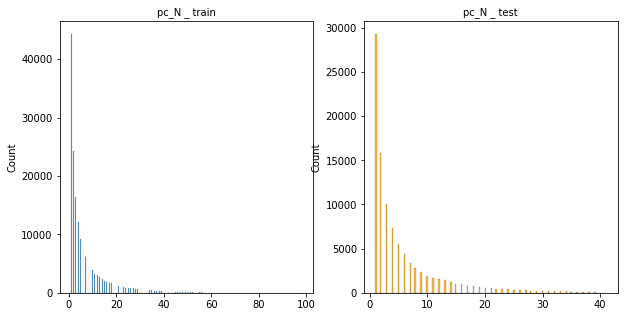

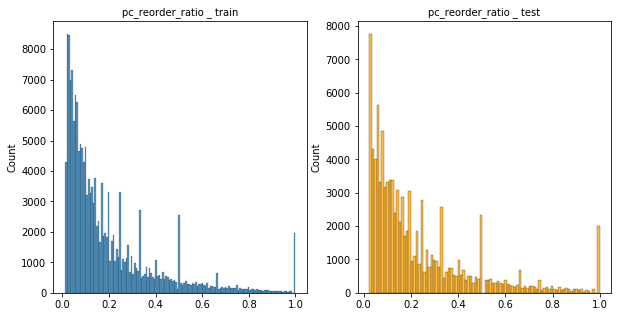

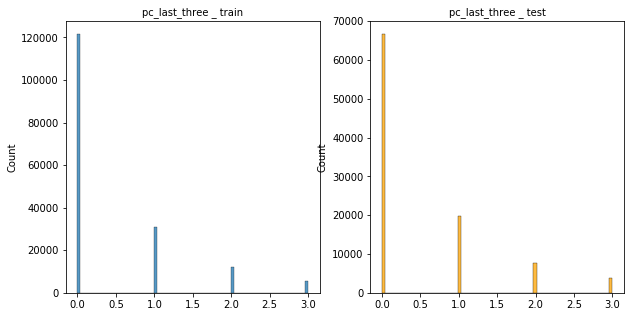

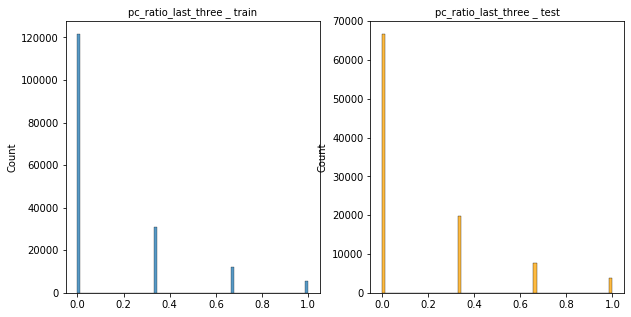

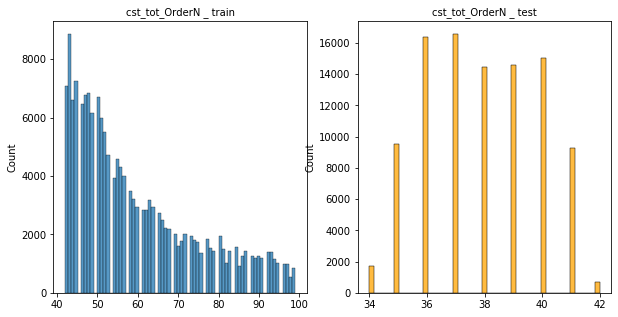

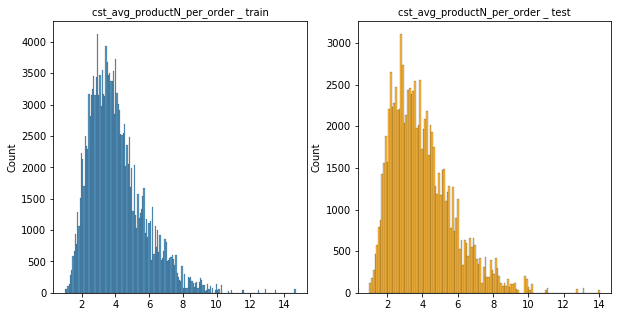

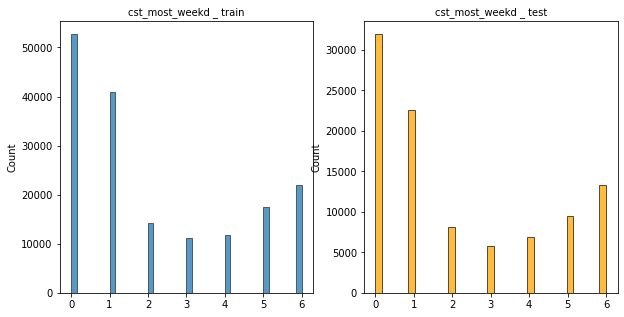

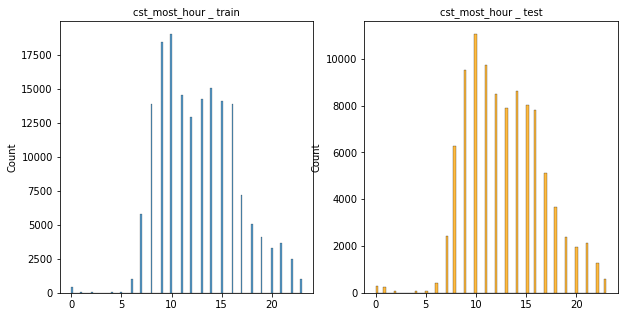

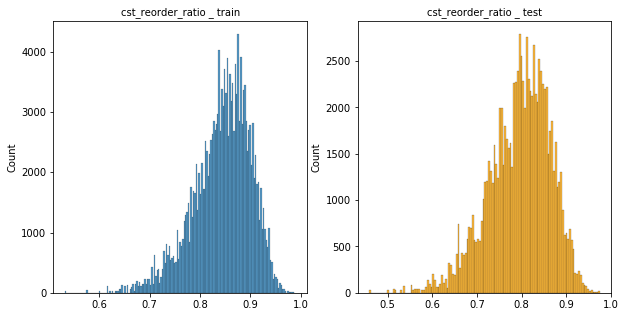

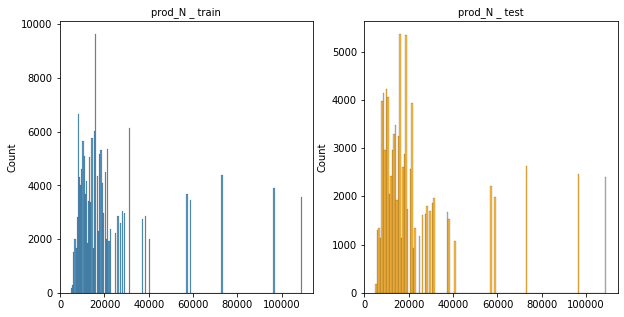

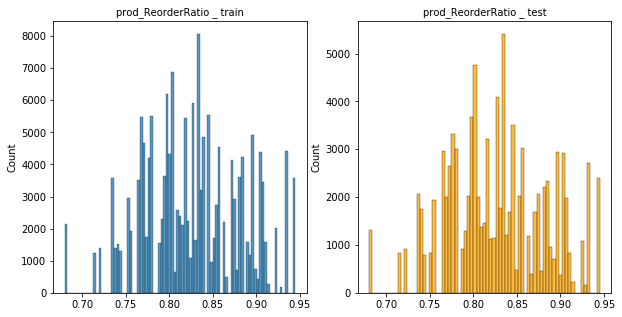

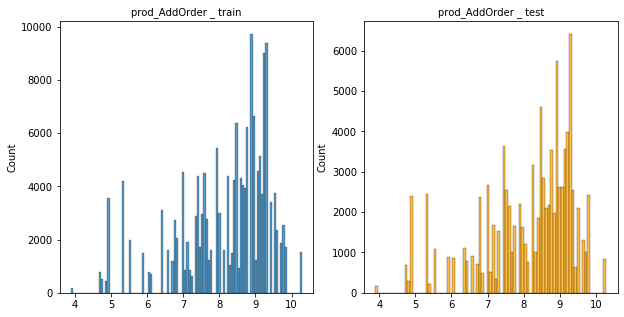

In [124]:
a = ['pc_N', 'pc_reorder_ratio', 'pc_last_three', 'pc_ratio_last_three', 'cst_tot_OrderN', 'cst_avg_productN_per_order'
     , 'cst_most_weekd', 'cst_most_hour', 'cst_reorder_ratio', 'prod_N', 'prod_ReorderRatio', 'prod_AddOrder']
b = [1,2,3,4,5,6,7,8,9,10,11,12]
    
for i in range(12):

    v1_sm = pd.concat([final_data[a[i]].describe(), train_data[a[i]].describe(), test_data[a[i]].describe()], axis = 1)
    v1_sm.loc['skewness'] = [final_data[a[i]].skew(), train_data[a[i]].skew(), test_data[a[i]].skew()]
    v1_sm

    plt.figure(figsize = (10, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(train_data[a[i]].values)
    plt.title(str(a[i] + " _ train"), fontsize=10)
    plt.subplot(1, 2, 2)
    sns.histplot(test_data[a[i]].values, color = 'orange')
    plt.title(str(a[i] + " _ test"), fontsize=10)
        
    plt.show()

# Step5. Modeling

## 0. train vs valid --- 변수/DF 생성

In [125]:
# train_x_current
df_train_x_current.tail()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,eval_set
24419,3184000,174046,100,5,7,2.0,12,1,24852,train
24420,1754722,6710,100,5,11,3.0,21,1,24852,train
24421,1076973,150840,100,0,13,0.0,18,1,24852,train
24422,1247049,99707,100,1,13,3.0,6,1,24852,train
24423,1775787,201038,100,5,9,2.0,1,1,24852,train


In [126]:
# 고객단위 DF 생성
df_train_x_current_cst = df_train_x_current.groupby(['cstno'], dropna=False).agg(cnt=('order_id','nunique')) 
df_train_x_current_cst = df_train_x_current_cst.reset_index().sort_values('cnt') 
df_train_x_current_cst

,cstno,cnt
0,50,1
3910,138401,1
3909,138392,1
3908,138315,1
3907,138307,1
...,...,...
1949,68347,1
1948,68317,1
1947,68309,1
1945,68299,1


In [127]:
# train vs valid 생성 (7:3)
from sklearn.model_selection import train_test_split 
cst_train_p, cst_valid_p = train_test_split(df_train_x_current_cst, 
                                            test_size=0.3, 
                                            shuffle=True, 
                                            random_state=566601 
                                            ) 

In [128]:
# flag 생성
cst_train_p.insert(2, 'train_flag', 'train')
cst_valid_p.insert(2, 'train_flag', 'valid')

In [129]:
# 검증
print(cst_train_p.shape)
print(cst_valid_p.shape)

(4101, 3)
(1758, 3)


In [130]:
# union all
cst_flag = pd.concat([cst_train_p,cst_valid_p]).drop(['cnt'], axis=1)
cst_flag['cstno'] = cst_flag['cstno'].astype(int)

In [131]:
# 검증
cst_flag['train_flag'].value_counts()

train    4101
valid    1758
Name: train_flag, dtype: int64

In [132]:
# train 전체 Data 에 flag 붙이기
train_data = train_data.merge(cst_flag, on='cstno', how='left')

* 변수/DF 생성

In [133]:
# train 
train_data_train = train_data.loc[train_data['train_flag']=='train']
train_data_valid = train_data.loc[train_data['train_flag']=='valid']
# 검증
print(train_data_train.shape)
print(train_data_valid.shape)

(118929, 16)
(51269, 16)


In [164]:
# X,y변수 및 X,y 데이터 생성 

pk_col = ['cstno','product_id','order_id','train_flag','cst_tot_OrderN'] # 제외컬럼 (pk 및 제외할 변수)
y_col = ['is_reordered'] 
X_col = [x for x in train_data.columns if x not in (pk_col+y_col)] # X변수 (제외 : pk, y 변수) 

# train
X_train = train_data_train[X_col] 
y_train = train_data_train[y_col] 

# valid
X_valid = train_data_valid[X_col]
y_valid = train_data_valid[y_col]

# test
X_test = test_data[X_col]

In [135]:
import numpy as np    #linear algebra
import pandas as pd   # data processing, CSV file 1/0 (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, model_selection
from tensorflow.keras.models import load_model
from numpy import loadtxt
import xgboost as xgb
from xgboost import XGBClassifier 
from sklearn.model_selection import train_test_split

import lightgbm as lgb
color = sns.color_palette()
%matplotlib inline
pd.options.mode.chained_assignment = None
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import pickle

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
import numpy as np
from tensorflow.keras.layers import Input, LSTM, Dense
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from tensorflow.keras.models import Model
import tensorflow as tf
import pandas as pd

import os
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, Activation, Dropout, Flatten
from tensorflow.keras.models import Model

## 1. Logistic Regression
    - train : f1 0.249
    - valid : f1 0.256

### 1-1. 모델링 

In [136]:
model = LogisticRegression(solver='saga', tol=1e-4, max_iter=1000, random_state=0, C = i,n_jobs = -1)
model.fit(X_train, y_train)
from sklearn.metrics import f1_score
print('Train f1 score', f1_score(y_train, model.predict(X_train)))
print('Test f1 score', f1_score(y_valid, model.predict(X_valid)))

/opt/conda/envs/python3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Train f1 score 0.0038699207290431308
Test f1 score 0.00256446787291637


/opt/conda/envs/python3.6/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [137]:
model = LogisticRegression(solver='saga', tol=1e-4, max_iter=3000, random_state=0, C = i,n_jobs = -1)
model.fit(X_train, y_train)
from sklearn.metrics import f1_score
print('Train f1 score', f1_score(y_train, model.predict(X_train)))
print('Test f1 score', f1_score(y_valid, model.predict(X_valid)))

/opt/conda/envs/python3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Train f1 score 0.07392489041582752
Test f1 score 0.08091706001348618


/opt/conda/envs/python3.6/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [138]:
model = LogisticRegression(solver='saga', tol=1e-4, max_iter=5000, random_state=0, C = i,n_jobs = -1)
model.fit(X_train, y_train)
from sklearn.metrics import f1_score
print('Train f1 score', f1_score(y_train, model.predict(X_train)))
print('Test f1 score', f1_score(y_valid, model.predict(X_valid)))

/opt/conda/envs/python3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Train f1 score 0.14044125881957667
Test f1 score 0.1521269841269841


In [139]:
model = LogisticRegression(solver='saga', tol=1e-4, max_iter=7000, random_state=0, C = i,n_jobs = -1)
model.fit(X_train, y_train)
from sklearn.metrics import f1_score
print('Train f1 score', f1_score(y_train, model.predict(X_train)))
print('Test f1 score', f1_score(y_valid, model.predict(X_valid)))

/opt/conda/envs/python3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Train f1 score 0.14044125881957667
Test f1 score 0.1521269841269841


* max_iter=5000 이후로 Train f1 score, Test f1 score이 각각 0.14, 0.15로 수렴함.<br>
  따라서 Logistic Regression 모델의 max_iter=5000으로 선택.

/opt/conda/envs/python3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


C1 =  0.001 Train Score 0.14026439614609007 test Score 0.15191159659596087


/opt/conda/envs/python3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


C1 =  0.01 Train Score 0.14044912359298875 test Score 0.1521463042926086


/opt/conda/envs/python3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


C1 =  0.1 Train Score 0.14044125881957667 test Score 0.1521269841269841


/opt/conda/envs/python3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


C1 =  1 Train Score 0.14044125881957667 test Score 0.1521269841269841


/opt/conda/envs/python3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


C1 =  10 Train Score 0.14044125881957667 test Score 0.1521269841269841


/opt/conda/envs/python3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


C1 =  100 Train Score 0.14044125881957667 test Score 0.1521269841269841


Text(0.5, 1.0, 'C1 vs score at max_iter of 5000')

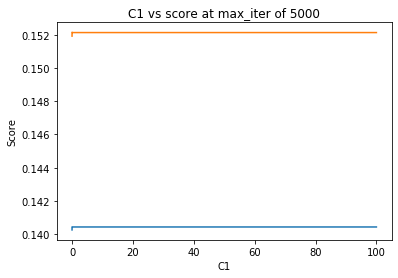

In [140]:
C1=[10 ** x for x in range(-3, 3)]
train_scores = []
test_scores = []
for i in C1:
    model = LogisticRegression(solver='saga', tol=1e-4, max_iter=5000, random_state=0, C = i,n_jobs = -1)
    model.fit(X_train,y_train)
    train_sc = f1_score(y_train, model.predict(X_train))
    test_sc = f1_score(y_valid, model.predict(X_valid))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('C1 = ', i, 'Train Score', train_sc, 'test Score', test_sc)
    
    #recall = recall_score(y_train, y_pred, average='')
    
plt.plot(C1, train_scores, label='Train Score')
plt.plot(C1, test_scores, label='Test Score')
plt.xlabel('C1')
plt.ylabel('Score')
plt.title('C1 vs score at max_iter of 5000')

* C값의 변화에도 train score과 test score이 동일함을 확인.

In [141]:
model = LogisticRegression(solver='saga', tol=1e-4, max_iter=5000, random_state=0, C = i,n_jobs = -1)
model.fit(X_train, y_train)

/opt/conda/envs/python3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(C=100, max_iter=5000, n_jobs=-1, random_state=0,
                   solver='saga')

In [206]:
from sklearn.metrics import f1_score
print('Train f1 score', f1_score(y_train, model.predict(X_train)))
print('Valid f1 score', f1_score(y_valid, model.predict(X_valid)))

Train f1 score 0.14044125881957667
Valid f1 score 0.1521269841269841


## 2. Random Forest
    - train : f1 0.438
    - valid : f1 0.433

In [143]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

/opt/conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


Estimators =  50 Train Score 0.4416070820565202 test Score 0.4346395742622158


/opt/conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


Estimators =  100 Train Score 0.4389682370496696 test Score 0.43581800580832525


/opt/conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


Estimators =  250 Train Score 0.43968423298485176 test Score 0.433582742201924


/opt/conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


Estimators =  450 Train Score 0.43991297299603266 test Score 0.4337091757387247


Text(0.5, 1.0, 'Estimators vs score at depth of 10')

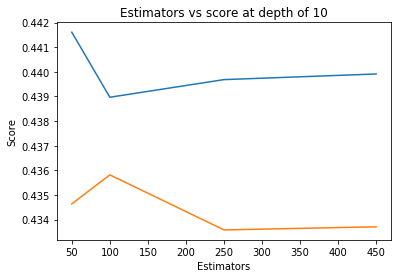

In [144]:
estimators = [50, 100, 250, 450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                                 max_depth=10, max_features='auto', max_leaf_nodes=None,
                                 min_impurity_decrease=0.0, min_impurity_split=None,
                                 min_samples_leaf=52, min_samples_split=120,
                                 min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1, random_state=10, verbose=0, warm_start=False)
    clf.fit(X_train, y_train)
    train_sc = f1_score(y_train, clf.predict(X_train))
    test_sc = f1_score(y_valid, clf.predict(X_valid))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i, 'Train Score', train_sc, 'test Score', test_sc)
plt.plot(estimators, train_scores, label='Train Score')
plt.plot(estimators, test_scores, label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 10')

In [145]:
#from above plot, at n_estimators=250 gives best result
clf_random = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                                 max_depth=10, max_features='auto', max_leaf_nodes=None,
                                 min_impurity_decrease=0.0, min_impurity_split=None,
                                 min_samples_leaf=52, min_samples_split=120,
                                 min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1, random_state=10, verbose=0, warm_start=False)
clf_random.fit(X_train, y_train)

/opt/conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(max_depth=10, min_samples_leaf=52, min_samples_split=120,
                       n_estimators=250, n_jobs=-1, random_state=10)

In [146]:
print('Train f1 score', f1_score(y_train, clf_random.predict(X_train)))
print('Valid f1 score', f1_score(y_valid, clf_random.predict(X_valid)))

Train f1 score 0.43968423298485176
Test f1 score 0.433582742201924


## 3. LGBM Classifier
    - train : f1 0.518
    - valid : f1 0.524

### 3-1. Best parameter 선정

In [ ]:
lgbm=lgb.LGBMClassifier(n_jobs=-1)
prams={
      'learning_rate':[0.001, 0.01, 0.1],
      'n_estimators':[100,500,1000,1500],
      'max_depth':[5,10,15,20],
      'num_leaves':[25,50,75],
      'class_weight':[{0:1,1:2},{0:1,1:4},{0:1,1:6}],}

lgbm_cfl1=RandomizedSearchCV(lgbm,param_distributions=prams, scoring='f1', return_train_score=True, cv=3)
lgbm_cfl1.fit(X_train, y_train)
lgbm_cfl1.best_params_

In [161]:
lgbm_cfl1.best_params_

{'num_leaves': 50,
 'n_estimators': 100,
 'max_depth': 15,
 'learning_rate': 0.01,
 'class_weight': {0: 1, 1: 4}}

In [148]:
lgbm=lgb.LGBMClassifier(class_weight={0:1,1:4}, learning_rate=0.001, max_depth=15, n_estimators=1000, num_leaves=25, random_state=0)
lgbm.fit(X_train, y_train)

/opt/conda/envs/python3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/conda/envs/python3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LGBMClassifier(class_weight={0: 1, 1: 4}, learning_rate=0.001, max_depth=15,
               n_estimators=1000, num_leaves=25, random_state=0)

In [149]:
from sklearn.metrics import f1_score
print('Train f1 score', f1_score(y_train, lgbm.predict(X_train)))
print('Valid f1 score', f1_score(y_valid, lgbm.predict(X_valid)))

Train f1 score 0.5216724421973526
Test f1 score 0.5256552715863783


## 4. XGBoost
    - train : f1 0.547
    - valid : f1 0.523

### 4-1. 모델링 / GridSearch

In [157]:
# 모듈
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report 

In [151]:
parameters = {"max_depth":[5,8,9],          # 트리의 최대 깊이 
              "colsample_bytree":[0.3, 0.4]  # 각 스텝마다 (트리마다) 사용할 feature의 비율 (0~1사이값) (like. max_feature)
             }

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', # 목적합수 : 이항분류시 사용하는 함수사용
                                   eval_metric='logloss',       # 평가지표 : Negative log=likelihood
                                   num_boost_round=10           # 몇회의 스텝을 반복할지 지정
                                  )

gridsearch = GridSearchCV(xgb_classifier, parameters, cv=5, verbose=2, n_jobs=-1)
xgb_model = gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/conda/envs/python3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/envs/python3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/conda/envs/python3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwa

[21:38:43] WARNING: ../src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




### 4-2. Best Model 선정 및 feauture importance 확인

In [152]:
# Best Model
xgb_optimal_model = gridsearch.best_estimator_

In [153]:
# Best Model - 파라미터 확인  === max_depth:5 , gamma : 0 등
xgb_optimal_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.3,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 48,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'logloss',
 'num_boost_round': 10}

* feature importance 확인  
   (1) pc_reorder_ratio : 고객/상품별 재구매 비율  
   (2) cst_avg_productN_per_order : 고객별 평균 상품주문 건수  
   (3) prod_ReorderRatio : 상품별 재구매율

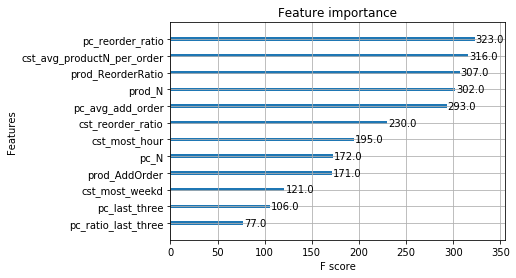

In [154]:
# Best Model - feature importance
xgb.plot_importance(xgb_optimal_model)

### 4-3. train/valid 데이터 - 재구매 상품 여부 / 성능평가 

* train : f1 0.547

In [155]:
# 최종 재구매 상품여부 --- 재구매 확률 0.27이상인 것은 재구매 한 것으로 판단.
y_train_pred = (xgb_optimal_model.predict_proba(X_train)[:, 1] >= 0.27).astype(int)
y_train_pred[:10] # 재구매 상품여부 (0,1) 체크 

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [158]:
print(f'f1 Score: {f1_score(y_train_pred, y_train)}')
print(classification_report(y_train_pred, y_train))

f1 Score: 0.5474238702613122
              precision    recall  f1-score   support

           0       0.92      0.93      0.93    101120
           1       0.58      0.52      0.55     17809

    accuracy                           0.87    118929
   macro avg       0.75      0.73      0.74    118929
weighted avg       0.87      0.87      0.87    118929



* valid : f1 0.523

In [159]:
# 최종 재구매 상품여부 --- 재구매 확률 0.21이상인 것은 재구매 한 것으로 판단.
y_valid_pred = (xgb_optimal_model.predict_proba(X_valid)[:, 1] >= 0.27).astype(int)

In [160]:
print(f'f1 Score: {f1_score(y_valid_pred, y_valid)}')
print(classification_report(y_valid_pred, y_valid))

f1 Score: 0.5227427019687712
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     43544
           1       0.55      0.50      0.52      7725

    accuracy                           0.86     51269
   macro avg       0.73      0.71      0.72     51269
weighted avg       0.86      0.86      0.86     51269



# Step6. 최종결과  

> * 최종모델선정 및 test_y 예측
>
> * 1. 최종모델  
>      (1) 최종모델 선정 : XGBoost
>            - Step5의 Modeling 실험결과 반영 (train 및 valid 의 f1 스코어가 높은 실험 선택)
>      (2) parameter : 'gamma': 0, max_depth': 5, 'n_estimators': 100, 'colsample_bytree': 0.3  
>      (3) 상위 변수 : 
>           pc_reorder_ratio : 고객/상품별 재구매 비율  
>           cst_avg_productN_per_order : 고객별 평균 상품주문 건수  
>           prod_ReorderRatio : 상품별 재구매율
>          
> * 2. test_y   
>      (1) 최종모델을 통한 product_id 예측  
>      (2) 산출되지 않은 product_id 존재 : 과거 구매이력 존재하지 않은 상품  
>      (3) 이 경우 예측대상의 같은 구매조건의 최다구매상품으로 추가 예측 (동순위시 상품별 구매순위에 따름)

## 0. 모형결과 요약

In [212]:
x1 = pd.DataFrame({'Model' : ['Logistic Regression', 'Random Forest', 'LGBM Classifier', 'XGBoost'], 
                   'main parameter' : ['max_iter=5,000', 'n_estimators= 250', 'class_weight={0:1,1:4}', 'max_depth=5'],
                   'train f1-Score' : ['0.1404', '0.4396', '0.5216', '0.5474'],               
                   'valid f1-Score' : ['0.1521', '0.4335', '0.5256', '0.5227']})               
x1

,Model,main parameter,train f1-Score,valid f1-Score
0,Logistic Regression,"max_iter=5,000",0.1404,0.1521
1,Random Forest,n_estimators= 250,0.4396,0.4335
2,LGBM Classifier,"class_weight={0:1,1:4}",0.5216,0.5256
3,XGBoost,max_depth=5,0.5474,0.5227


## 1. test - 재구매 상품 예측

In [165]:
# 최종 재구매 상품여부 --- 재구매 확률 0.27이상인 것은 재구매 한 것으로 판단.
y_test_pred = (xgb_optimal_model.predict_proba(X_test)[:, 1] >= 0.27).astype(int)

In [166]:
# 최종 상품 재구매 확률
y_test_pred_proba = xgb_optimal_model.predict_proba(X_test)

In [167]:
# 점검 - 상품 재구매 확률 
y_test_pred_proba[:10,]

array([[0.9292913 , 0.07070867],
       [0.7535709 , 0.24642907],
       [0.6152538 , 0.38474616],
       [0.98489106, 0.01510896],
       [0.33355027, 0.6664497 ],
       [0.97038287, 0.02961714],
       [0.31658727, 0.68341273],
       [0.97413623, 0.02586374],
       [0.7820302 , 0.21796976],
       [0.9642044 , 0.0357956 ]], dtype=float32)

In [168]:
# 컬럼 붙이기 --- 재구매여부 / 재구매확률
X_test['y_pred'] = y_test_pred
X_test['y_pred_prob'] = y_test_pred_proba[:,1]

In [169]:
# 점검
X_test.head(10)

pc_N  pc_reorder_ratio  pc_last_three  pc_ratio_last_three  \
cstno product_id                                                               
63    4605           1          0.250000            0.0             0.000000   
      5876           5          0.172414            2.0             0.666667   
      8277          11          0.611111            1.0             0.333333   
      10749          1          0.028571            0.0             0.000000   
      13176         21          0.636364            3.0             1.000000   
      16797          1          0.047619            0.0             0.000000   
      21137         15          0.454545            3.0             1.000000   
      21903          1          0.055556            0.0             0.000000   
      22935          9          0.281250            1.0             0.333333   
      24184          2          0.076923            0.0             0.000000   

                  pc_avg_add_order  cst_avg_productN_per_order  \
cstno product_id                                                 
63    4605                9.000000                    3.228571   
      5876                6.600000                    3.228571   
      8277                3.363636                    3.228571   
      10749               3.000000                    3.228571   
      13176               7.809524                    3.228571   
      16797               1.000000                    3.228571   
      21137               6.466667                    3.228571   
      21903               2.000000                    3.228571   
      22935               7.777778                    3.228571   
      24184               6.000000                    3.228571   

                  cst_most_weekd  cst_most_hour  cst_reorder_ratio  prod_N  \
cstno product_id                                                             
63    4605                     1             12           0.796387   12672   
      5876                     1             12           0.796387   22434   
      8277                     1             12           0.796387   24867   
      10749                    1             12           0.796387   15537   
      13176                    1             12           0.796387   96600   
      16797                    1             12           0.796387   27104   
      21137                    1             12           0.796387   72981   
      21903                    1             12           0.796387   57086   
      22935                    1             12           0.796387   29228   
      24184                    1             12           0.796387   11740   

                  prod_ReorderRatio  prod_AddOrder  y_pred  y_pred_prob  
cstno product_id                                                         
63    4605                 0.755840       8.888889       0     0.070709  
      5876                 0.833690       8.244495       0     0.246429  
      8277                 0.863152       7.502674       1     0.384746  
      10749                0.802793       8.948446       0     0.015109  
      13176                0.934058       5.320797       1     0.666450  
      16797                0.844045       7.615038       0     0.029617  
      21137                0.903632       7.432058       1     0.683413  
      21903                0.897050       7.922993       0     0.025864  
      22935                0.840153       8.784008       0     0.217970  
      24184                0.788075       8.923509       0     0.035796

In [170]:
# 점검
X_test['y_pred'].value_counts()

0    81969
1    16234
Name: y_pred, dtype: int64

## 2. 고객별 / 상품 재구매확률별 순위 (rank)  
   * 순위 : (1)고객별 (2)상품 재구매확률별 (3)Addorder별
   * 순위대로 예측해야할 재구매상품 개수만큼 상품 추출하여 최종 "test_y" 생성

In [171]:
# 정렬 : (1)고객별 (2)상품재구매확률별 (3)Addorder별
X_test_2 = X_test.sort_values(['cstno','y_pred_prob','prod_AddOrder'], ascending=[True,False,True] )

In [172]:
# 순위 : 위 정렬순서대로 
# method = 'first' : 동순위 내에서 row 표시되는 순서대로 순위부여 (공동 등수라면 데이터 적재된 순서대로 순위부여)
X_test_2['rank'] = X_test_2.groupby(['cstno'])['y_pred_prob'].rank(method='first', ascending=False).astype(int)

In [173]:
X_test_2.reset_index(inplace=True)
X_test_2.head(10)

,cstno,product_id,pc_N,pc_reorder_ratio,pc_last_three,pc_ratio_last_three,pc_avg_add_order,cst_avg_productN_per_order,cst_most_weekd,cst_most_hour,cst_reorder_ratio,prod_N,prod_ReorderRatio,prod_AddOrder,y_pred,y_pred_prob,rank
0,63,21137,15,0.454545,3.0,1.000000,6.466667,3.228571,1,12,0.796387,72981,0.903632,7.432058,1,0.683413,1
1,63,13176,21,0.636364,3.0,1.000000,7.809524,3.228571,1,12,0.796387,96600,0.934058,5.320797,1,0.666450,2
2,63,8277,11,0.611111,1.0,0.333333,3.363636,3.228571,1,12,0.796387,24867,0.863152,7.502674,1,0.384746,3
3,63,5876,5,0.172414,2.0,0.666667,6.600000,3.228571,1,12,0.796387,22434,0.833690,8.244495,0,0.246429,4
4,63,24964,6,0.272727,2.0,0.666667,8.666667,3.228571,1,12,0.796387,27996,0.826940,8.963245,0,0.222816,5
5,63,22935,9,0.281250,1.0,0.333333,7.777778,3.228571,1,12,0.796387,29228,0.840153,8.784008,0,0.217970,6
6,63,49235,12,0.428571,0.0,0.000000,6.583333,3.228571,1,12,0.796387,19244,0.896539,6.385159,0,0.197471,7
7,63,47209,10,0.344828,0.0,0.000000,5.600000,3.228571,1,12,0.796387,58841,0.907361,6.996822,0,0.149096,8
8,63,30391,2,0.200000,0.0,0.000000,2.500000,3.228571,1,12,0.796387,21286,0.834868,8.630602,0,0.087371,9
9,63,27104,4,0.166667,0.0,0.000000,10.000000,3.228571,1,12,0.796387,17245,0.790954,9.325602,0,0.085579,10


## 3. 추출해야 할 재구매 예측 상품 개수 파악

* test_x_current 에서 파악

In [174]:
# test_x_current ---->위에서 만들었으면 굳이 만들지 않아도 되는 단계
sql = 'SELECT * FROM test_x_current'
test_x_current = get_df(sql, schema)
test_x_current = test_x_current.apply(pd.to_numeric, errors='coerce').fillna(0)
test_x_current.tail()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered
16121,2047884,57077,46,5,15,8.0,2,1
16122,567625,83592,43,4,12,0.0,1,1
16123,596442,157740,49,6,10,3.0,2,1
16124,671102,92043,43,4,10,10.0,1,1
16125,529654,62871,58,4,8,8.0,22,1


In [175]:
# 예측건수 확인
test_x_current.shape

(16126, 8)

In [176]:
# 고객별 --- 예측해야할 상품 개수
cst_cnt_pred_product = test_x_current.groupby(['cstno']).agg(cnt_pred_product=('add_order','count')).reset_index().sort_values(['cnt_pred_product','cstno'])
cst_cnt_pred_product.tail(5)

,cstno,cnt_pred_product
2068,103480,17
3936,197031,17
553,28705,18
3180,159609,18
3973,198856,20


In [177]:
# 고객별 예측해야할 상품 개수 붙이기
X_test_3 = X_test_2.merge(cst_cnt_pred_product, on='cstno', how='left')
X_test_3.tail(5)

,cstno,product_id,pc_N,pc_reorder_ratio,pc_last_three,pc_ratio_last_three,pc_avg_add_order,cst_avg_productN_per_order,cst_most_weekd,cst_most_hour,cst_reorder_ratio,prod_N,prod_ReorderRatio,prod_AddOrder,y_pred,y_pred_prob,rank,cnt_pred_product
98198,206193,5450,1,0.052632,0.0,0.0,2.0,2.421053,1,9,0.739258,10439,0.811859,7.728326,0,0.018194,20,3
98199,206193,39275,2,0.052632,0.0,0.0,2.5,2.421053,1,9,0.739258,21599,0.780268,8.587805,0,0.017688,21,3
98200,206193,33731,1,0.037037,0.0,0.0,2.0,2.421053,1,9,0.739258,12011,0.775040,9.835151,0,0.013704,22,3
98201,206193,28842,1,0.050000,0.0,0.0,10.0,2.421053,1,9,0.739258,8312,0.721246,9.264678,0,0.012313,23,3
98202,206193,39928,1,0.027778,0.0,0.0,1.0,2.421053,1,9,0.739258,14757,0.831538,8.880938,0,0.008513,24,3


* 고객별 재구매 상품 예측 최종  
  -- 3건 예측 되지 않음 (과거 구매이력이 있는 상품보다 더 많은 상품을 주문한 고객인 경우)

In [178]:
# 우선순위가 예측해야할 재구매상품 개수만큼만 
X_test_4 = X_test_3.loc[X_test_3['rank'] <= X_test_3['cnt_pred_product']]

In [179]:
# 점검
X_test_4.shape

(16123, 18)

In [180]:
# 점검
X_test_4

,cstno,product_id,pc_N,pc_reorder_ratio,pc_last_three,pc_ratio_last_three,pc_avg_add_order,cst_avg_productN_per_order,cst_most_weekd,cst_most_hour,cst_reorder_ratio,prod_N,prod_ReorderRatio,prod_AddOrder,y_pred,y_pred_prob,rank,cnt_pred_product
0,63,21137,15,0.454545,3.0,1.000000,6.466667,3.228571,1,12,0.796387,72981,0.903632,7.432058,1,0.683413,1,3
1,63,13176,21,0.636364,3.0,1.000000,7.809524,3.228571,1,12,0.796387,96600,0.934058,5.320797,1,0.666450,2,3
2,63,8277,11,0.611111,1.0,0.333333,3.363636,3.228571,1,12,0.796387,24867,0.863152,7.502674,1,0.384746,3,3
23,142,13176,18,0.692308,3.0,1.000000,2.833333,3.292683,5,14,0.829590,96600,0.934058,5.320797,1,0.723753,1,1
46,173,13176,8,0.400000,1.0,0.333333,4.250000,3.081081,2,10,0.728027,96600,0.934058,5.320797,1,0.407831,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98149,206174,21137,11,0.289474,1.0,0.333333,8.363636,2.463415,2,9,0.703125,72981,0.903632,7.432058,0,0.268522,1,2
98150,206174,40706,9,0.230769,1.0,0.333333,4.666667,2.463415,2,9,0.703125,20626,0.804470,9.781441,0,0.246807,2,2
98179,206193,13176,18,0.642857,3.0,1.000000,3.666667,2.421053,1,9,0.739258,96600,0.934058,5.320797,1,0.631984,1,3
98180,206193,5876,6,0.300000,2.0,0.666667,6.333333,2.421053,1,9,0.739258,22434,0.833690,8.244495,0,0.257786,2,3


## 4. test_x_current에 예측한 상품 붙이기

In [181]:
# 고유번호 만들기 -- 추후 "test_y" 생성시 필요
test_x_current_2 = test_x_current.reset_index()
test_x_current_2.tail(5)

,index,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered
16121,16121,2047884,57077,46,5,15,8.0,2,1
16122,16122,567625,83592,43,4,12,0.0,1,1
16123,16123,596442,157740,49,6,10,3.0,2,1
16124,16124,671102,92043,43,4,10,10.0,1,1
16125,16125,529654,62871,58,4,8,8.0,22,1


In [182]:
# 정렬 후 순번
test_x_current_2.sort_values(['cstno','order_id','add_order'], ascending=[True,True,True], inplace=True)

In [183]:
# 순번 : rank(add_order)
# method = 'first' : 동순위 내에서 row 표시되는 순서대로 순위부여 (공동 등수라면 데이터 적재된 순서대로 순위부여)
test_x_current_2['rank'] = test_x_current_2.groupby(['cstno'])['add_order'].rank(method='first', ascending=True).astype(int)

In [184]:
# 점검
test_x_current_2.head(10)

,index,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,rank
1060,1060,2989905,63,40,6,8,13.0,2,0,1
8852,8852,2989905,63,40,6,8,13.0,6,1,2
8438,8438,2989905,63,40,6,8,13.0,9,1,3
5718,5718,2696946,142,46,6,17,2.0,4,0,1
5618,5618,2060922,173,45,2,9,15.0,1,1,1
11805,11805,2525899,236,44,5,15,6.0,1,1,1
10324,10324,2525899,236,44,5,15,6.0,5,0,2
9394,9394,3059590,280,42,1,6,8.0,4,1,1
7901,7901,3059590,280,42,1,6,8.0,5,1,2
8835,8835,3059590,280,42,1,6,8.0,6,1,3


In [185]:
# 상품붙이기 --- 확률우선순위==add_order_new
test_x_current_3 = test_x_current_2.merge(X_test_4[['cstno','rank','y_pred','y_pred_prob','product_id']], on=['cstno','rank'], how='left')
# test_x_current_3 = test_x_current_3['product_id'].astype(int)
test_x_current_3.shape

(16126, 13)

## 5. 결측치 처리  
   * 결측치 처리 :  구매조건의 최다구매상품으로 추가 예측 (동순위시 상품별 구매순위에 따름)

In [186]:
# 결측치 확인 --- 3건
test_x_current_3[test_x_current_3['product_id'].isnull()]

,index,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,rank,y_pred,y_pred_prob,product_id
2830,9434,2321011,38151,49,6,10,7.0,13,0,2,NaN,NaN,NaN
5466,97,2515943,71975,40,3,8,6.0,2,0,2,NaN,NaN,NaN
10957,9528,3034773,142487,44,1,6,30.0,9,0,3,NaN,NaN,NaN


In [187]:
# past 불러오기
sql = 'SELECT * FROM test_x_past'
df_test_x_past = get_df(sql, schema)
df_test_x_past = df_test_x_past.apply(pd.to_numeric, errors='coerce').fillna(0)
df_test_x_past.tail()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
541917,2672845,119134,39,1,14,17.0,4,1,24852
541918,2731678,119134,38,5,14,3.0,4,1,24852
541919,2860406,119134,9,5,9,8.0,1,1,24852
541920,3252013,119134,4,5,10,7.0,2,1,24852
541921,3275894,119134,16,4,10,3.0,10,1,24852


In [188]:
# 구매조건별 최대구매상품 찾기
df_seg_1 = df_train_x_past.groupby(by=['week_day','order_hour','order_interval','product_id'])['cstno'].aggregate('count').to_frame('cnt_prod').reset_index()
df_seg_1.shape

(201857, 5)

In [189]:
# 상품별 구매순위
prod_tot_cnt = df_train_x_past.groupby(by=['product_id'])['cstno'].count().to_frame('prod_tot_cnt')

In [190]:
# 구매조건별 최대구매상품 + 상품별 구매순위 
df_seg_2 = df_seg_1.merge(prod_tot_cnt, on='product_id', how='left')

In [191]:
# 정렬 : (1)구매조건별 최대구매상품 (2)상품별 구매순위
df_seg_2.sort_values(['week_day','order_hour','order_interval','cnt_prod','prod_tot_cnt'], ascending=[True,True,True,True,True], inplace=True)

In [192]:
# Last 건 추출
df_seg_3 = df_seg_2.drop_duplicates(['week_day','order_hour','order_interval'],keep='last')
df_seg_4 = df_seg_3.rename(columns={'product_id':'product_id_add'})
df_seg_4.drop(['cnt_prod','prod_tot_cnt'], axis=1, inplace=True)
df_seg_4.head(10)

,week_day,order_hour,order_interval,product_id_add
3,0,0,0.0,13176
32,0,0,1.0,13176
73,0,0,2.0,24852
116,0,0,3.0,13176
173,0,0,4.0,13176
244,0,0,5.0,13176
330,0,0,6.0,24852
404,0,0,7.0,24852
483,0,0,8.0,24852
538,0,0,9.0,21903


* 결측치에 붙이기

In [193]:
# product_id_add 붙이기
test_x_current_4 = test_x_current_3.merge(df_seg_4, on=['week_day','order_hour','order_interval'], how='left')
# product_id_final 생성 : product_id null 인 경우 _add로 
test_x_current_4['product_id_final'] = np.where(test_x_current_4['product_id'].isna(),test_x_current_4['product_id_add'], test_x_current_4['product_id'])
# 타입변경
test_x_current_4['product_id_final'] = test_x_current_4['product_id_final'].astype(int)
test_x_current_4

,index,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,rank,y_pred,y_pred_prob,product_id,product_id_add,product_id_final
0,1060,2989905,63,40,6,8,13.0,2,0,1,1.0,0.683413,21137.0,24852.0,21137
1,8852,2989905,63,40,6,8,13.0,6,1,2,1.0,0.666450,13176.0,24852.0,13176
2,8438,2989905,63,40,6,8,13.0,9,1,3,1.0,0.384746,8277.0,24852.0,8277
3,5718,2696946,142,46,6,17,2.0,4,0,1,1.0,0.723753,13176.0,13176.0,13176
4,5618,2060922,173,45,2,9,15.0,1,1,1,1.0,0.407831,13176.0,24852.0,13176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16121,1708,1620607,206174,53,4,22,10.0,4,1,1,0.0,0.268522,21137.0,24852.0,21137
16122,8799,1620607,206174,53,4,22,10.0,7,1,2,0.0,0.246807,40706.0,24852.0,40706
16123,858,2518868,206193,42,5,12,5.0,3,1,1,1.0,0.631984,13176.0,24852.0,13176
16124,4433,2518868,206193,42,5,12,5.0,4,0,2,0.0,0.257786,5876.0,24852.0,5876


In [194]:
# 점검
test_x_current_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16126 entries, 0 to 16125
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             16126 non-null  int64  
 1   order_id          16126 non-null  int64  
 2   cstno             16126 non-null  int64  
 3   order_number      16126 non-null  int64  
 4   week_day          16126 non-null  int64  
 5   order_hour        16126 non-null  int64  
 6   order_interval    16126 non-null  float64
 7   add_order         16126 non-null  int64  
 8   is_reordered      16126 non-null  int64  
 9   rank              16126 non-null  int64  
 10  y_pred            16123 non-null  float64
 11  y_pred_prob       16123 non-null  float32
 12  product_id        16123 non-null  float64
 13  product_id_add    16004 non-null  float64
 14  product_id_final  16126 non-null  int64  
dtypes: float32(1), float64(4), int64(10)
memory usage: 1.9 MB


## 6. test_y.csv 생성

In [195]:
# product_id_final 타입변경
test_x_current_4 = test_x_current_4.astype({'product_id_final' : 'object'})

In [196]:
# 타입 확인 
test_x_current_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16126 entries, 0 to 16125
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             16126 non-null  int64  
 1   order_id          16126 non-null  int64  
 2   cstno             16126 non-null  int64  
 3   order_number      16126 non-null  int64  
 4   week_day          16126 non-null  int64  
 5   order_hour        16126 non-null  int64  
 6   order_interval    16126 non-null  float64
 7   add_order         16126 non-null  int64  
 8   is_reordered      16126 non-null  int64  
 9   rank              16126 non-null  int64  
 10  y_pred            16123 non-null  float64
 11  y_pred_prob       16123 non-null  float32
 12  product_id        16123 non-null  float64
 13  product_id_add    16004 non-null  float64
 14  product_id_final  16126 non-null  object 
dtypes: float32(1), float64(4), int64(9), object(1)
memory usage: 1.9+ MB


In [233]:
# 'index' 컬럼으로 정렬
test_x_current_4.sort_values('index')

,index,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,rank,y_pred,y_pred_prob,product_id,product_id_add,product_id_final
2820,0,3384204,37987,38,5,16,13.0,9,1,4,1.0,0.328902,27845.0,24852.0,27845
13018,1,2578612,169022,38,6,10,7.0,4,1,3,1.0,0.729884,21709.0,24852.0,21709
15606,2,188887,200090,45,5,16,30.0,5,1,3,1.0,0.501288,44632.0,21137.0,44632
11427,3,646772,149416,39,1,13,13.0,15,1,8,0.0,0.225769,4920.0,24852.0,4920
8725,4,300214,113836,42,3,10,17.0,1,1,1,1.0,0.306121,47209.0,24852.0,47209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4184,16121,2047884,57077,46,5,15,8.0,2,1,1,1.0,0.703194,24852.0,24852.0,24852
6527,16122,567625,83592,43,4,12,0.0,1,1,1,1.0,0.914672,24852.0,24852.0,24852
12089,16123,596442,157740,49,6,10,3.0,2,1,1,1.0,0.593608,27086.0,24852.0,27086
7150,16124,671102,92043,43,4,10,10.0,1,1,1,1.0,0.628555,24852.0,13176.0,24852


In [235]:
# csv 생성
test_x_current_4.sort_values('index')['product_id_final'].to_csv(f'test_y.csv', encoding='CP949', index=False)

# Step7. 제언 및 마무리

> * Logistic Regression, Random Forest, LGBM, XGBoost 모형 분석 결과, F1 Score가 가장 높았던 XGBoost를 최종모델로 선정하여 분석함.  
> * 이를 기반으로 고객의 과거 구매이력과 현재 구매정보 분석을 통한 상품의 재구매 가능성 예측이라는 프로젝트 초기 목표를 달성하였고, <br>
고객의 특성을 반영한 상품 추천을 통해 고객 거래 심화 및 기업 매출 증대로 이어질 것을 기대함. 
> * 과거 구매이력이 부족한 고객에 대한 분석은 향후 고객 클러스터링분석을 통한 군집 특성을 반영한다면 에측의 정확도가 상승할 것으로 예상됨.